First download the gear images using; 

* curl -O https://challenge.blob.core.windows.net/challengefiles/gear_images.zip
* curl -O https://storagetimscarfe.blob.core.windows.net/openhack/gear_images_test.zip
* unzip *.zip

Or in windows powershell;

* wget "https://challenge.blob.core.windows.net/challengefiles/gear_images.zip" -OutFile gear_images.zip
* wget "https://storagetimscarfe.blob.core.windows.net/openhack/gear_images_test.zip" -OutFile gear_images_test.zip
* unzip gear_images.zip

<img src="results.png" style="width:75%" />

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
import numpy as np
from PIL import Image, ImageOps, ImageChops
import cv2
import os
import pickle
from pipe import Pipe
from functools import reduce
import operator
from pipe import select,take,as_list
from sklearn import tree
from glob import glob
from PIL import Image
import numpy as np
import re

#Inline Matplot graphics into the notebook
%matplotlib inline 

def resizeImageToSquare(image, desiredSize):
    # old_size[0] is in (width, height) format
    oldSize = image.size

    ratio = float(desiredSize)/max(oldSize)
    newSize = tuple([int(x*ratio) for x in oldSize])

    image = image.resize(newSize, Image.BILINEAR)

    # create a new image and paste the resized on it
    resized = Image.new("L", (desiredSize, desiredSize), color=(255))
    resized.paste(image, ((desiredSize-newSize[0])//2,
                        (desiredSize-newSize[1])//2))
    return resized

* Load all the gear_images 
* Resize them to 128^2
* Make black and white (we don't want to learn particular colours of tents etc)
* Scale image numbers $\in [0,1]$

Note that we have two separate populations of images:

* The original open hack challenge set
* the set prepared by Tim with about 30 images per class. This set is slightly more "real world" i.e. avoiding the canonical white background shots where possible. Caveats being that this was hard to achieve in some cases, especially with crampons. Also as this is a classification problem (not multilabel) we tried to find images where there is only one class or one dominant class in the image. 

In [2]:
%%time

@Pipe
def as_npy(iterable):
    return np.array(iterable)

def getImageTypeFromPath(imagePath):
    return re.search('[^\w](\w+)[^\w]', imagePath)[1]

# note I have obfuscated the names so that people can not google the solutions
imageTypes = {
    'axes': 0, 
    'boots': 1, 
    'carabiners': 2,
    'crampons': 3, 
    'gloves': 4, 
    'hardshell_jackets': 5, 
    'harnesses': 6, 
    'helmets': 7, 
    'insulated_jackets': 8, 
    'pulleys': 9, 
    'rope': 10, 
    'tents': 11, 
}

imageTypesInverted = {v: k for k, v in imageTypes.items()}

def replaceBlack(t):
    t2 = t[1]
    t2[t2==0]=255
    return (t[0], t2)

def GetDataByFolder(path="gear_images/**/*"):
    
    xy = ( glob(path)  
        | select(lambda path: (imageTypes[getImageTypeFromPath(path)], Image.open(path)))     
        # make black and white
        | select(lambda t: (t[0], t[1].convert('L') ) )     
        # make square
        | select(lambda t: (t[0], resizeImageToSquare(t[1], 128)) )     
        | select(lambda t: (t[0], np.array(t[1]))) 
        # replace blacks with white, about 1/50 images load with a black background
        # I have absolutley no idea why...
        | select(replaceBlack)   
        # scale to [0,1]
        | select(lambda t: (t[0], t[1] / 255))     
        | as_list() )

    X = xy | select(lambda e: e[1]) | as_list() | as_npy()

    # flattened version for classical learning
    Xf = X.reshape( X.shape[0], reduce(operator.mul, X.shape[1:], 1)  )
    y = xy | select(lambda e: e[0]) | as_list() | as_npy()

    return X,y,Xf

X,y,Xf = GetDataByFolder()

X_test,y_test,Xf_test = GetDataByFolder("gear_images_test/**/*")

print("STANDARD: X", X.shape, "y", y.shape)
print("TEST: X", X_test.shape, "y", y_test.shape)

STANDARD: X (2122, 128, 128) y (2122,)
TEST: X (359, 128, 128) y (359,)
Wall time: 8.86 s


Let's plot some of the images so we can see what we are working with

In [3]:
def plotSome(x, y, name='axes'):
    fig = plt.figure(figsize=(8, 6))
    # plot several images
    for i in range(15):
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(x[y==imageTypes[name]][i], cmap=plt.cm.bone)

from random import randint
        
def plot16(x, rand=False, title=""):
    fig = plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xticks([]),plt.yticks([])
    plt.axis('off')
    # plot several images
    for i in range(15):
        
        img = i
        if rand==True:
            img = randint(0,x.shape[0])
        
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        
        
        ax.imshow(x[img], cmap=plt.cm.bone)
        ax.set_xlabel(img)

Let's visually inspect our dataset by running this a few times, this is great for sanity checking and looking for bugs in how we parsed the images. I already noticed that some of the images were loading in with a black background, I have no idea why! I put a hacky line of code in the loader to fix this i.e. setting all 0=>255

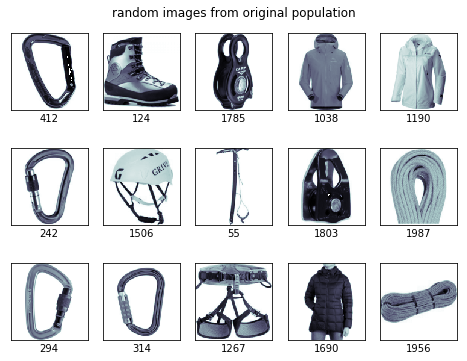

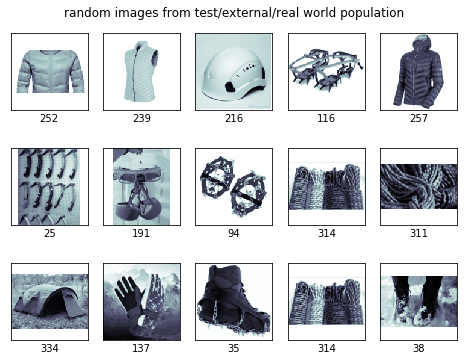

In [4]:
plot16(X, rand=True, title="random images from original population")
plot16(X_test, rand=True, title="random images from test/external/real world population")

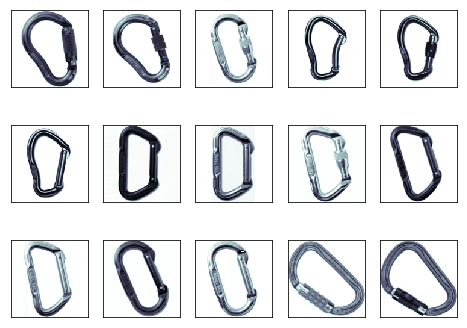

In [5]:
plotSome(X,y,'carabiners')

Let's try plotting one image for every class

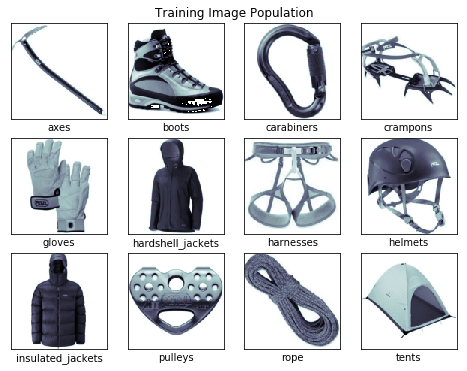

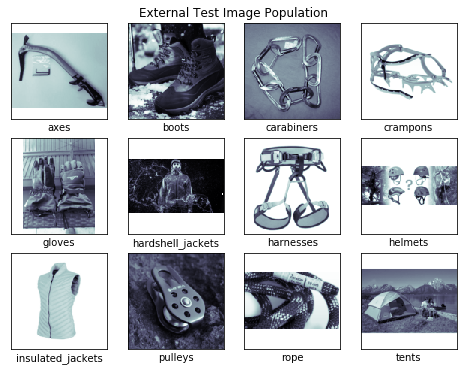

In [6]:
def PlotOneFromEachClass(x,y, title=""):
    
    fig = plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xticks([]),plt.yticks([])
    plt.axis('off')
    
    # plot several images
    i = 0
    for key in imageTypes.keys():
        ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
        
        ax.imshow(x[y==imageTypes[key]][0], cmap=plt.cm.bone)
        ax.set_xlabel(key)
        i = i + 1
    
    plt.show()
    
PlotOneFromEachClass(X,y, title="Training Image Population")
PlotOneFromEachClass(X_test,y_test, title="External Test Image Population")

Let's get a bit more clever now and plot an average image for each class. The result is pretty instructive;

* We can see that roughly half of the boots are inverted
* In most cases there is a clear "signature" to the class, this is part of why this challenge is quite contrived, similar to the MNIST challenge, it should be possible to guess what the class is merely by choosing values for pixels in certain areas. 

We also plot an average image for the external "real world" set of images, as you can see, these lose their regularity possibly apart from insulated jackets, crampons and harnesses -- these were the classes which I found it quite difficult to find likey real-world images which were not dominated by other classes (and we are modelling this as a classification problem)

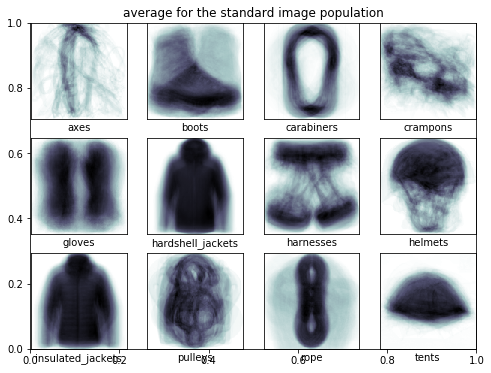

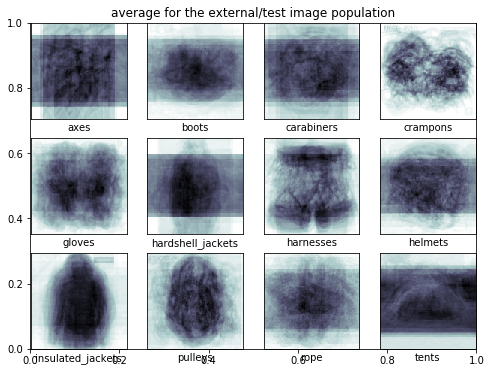

In [7]:
def plotAverage(x,y, title):
    fig = plt.figure(figsize=(8, 6))
    plt.title(title)
    # plot several images
    i = 0
    for key in imageTypes.keys():
        ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(x[y==imageTypes[key]].mean(axis=0), cmap=plt.cm.bone)
        ax.set_xlabel(key)
        i = i + 1
        
plotAverage(X,y, "average for the standard image population")
plotAverage(X_test,y_test, "average for the external/test image population")

Let's split the data into a test and train set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,
        y, random_state=0)

print(X_train.shape, X_val.shape)

(1591, 128, 128) (531, 128, 128)


Helper function to convert label indexes i.e. {0,1,2...} into labels i.e. {"axes","carabiners"...}

In [9]:
def ConvertIndexToLabel(indexes):
    return list( indexes ) | select( lambda i: imageTypesInverted[i] ) | as_list 

Here is a function which let's us plot a nice confusion matrix

In [10]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plotConfusion(yy, p, title='Confusion matrix'):
    cnf_matrix = metrics.confusion_matrix(yy, p)
    np.set_printoptions(precision=2)

    cm_labels = list(set(imageTypes.keys()))
    cm_labels.sort()

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                          title=title)

What is the average image over everything?

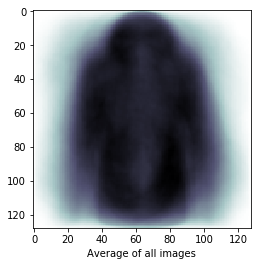

In [11]:
def PlotAverageImage(D):
    x = X.mean(axis=0).flatten()
    plt.imshow(D.mean(axis=0), cmap=plt.cm.bone)
    u = plt.xlabel( f"Average of all images" ) 

PlotAverageImage(X)

Jackets seem to be dominating, could this be because;

* The intensity values are higher in jackets
* There are more jackets overall (compounded by insulated jackets + normal jackets)

Note that the test set is balanced, or as near as makes no difference balanced 


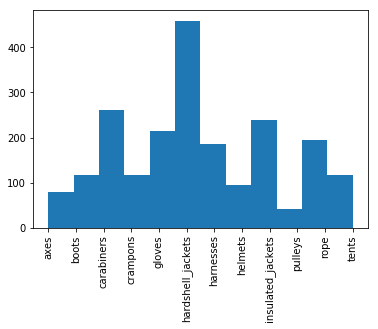

In [12]:
u = plt.hist(y, bins=12)
u = plt.xticks(range(12),imageTypes.keys(), rotation='vertical')

It does indeed appear that our hardshell jackets are dominating due to there being many more of them, also the jackets are around 200 and will have a similar profile which will compound the problem

Let's balance the distribution of classes by supersampling in the *train* split. It's important we don't do this on the test split too, as there would be many duplicate images in the test set and it would be trivial to memorise what they are. 

In [13]:
from pipe import chain, as_dict, Pipe, select, take, as_list

@Pipe
def pcycle(iterable):
    while True:
        for it in iterable:
            yield it
        
@Pipe
def as_npy(iterable):
    return np.array(iterable)

def balancedSignalGenerator(X,y,num_classes=12):
    
    class_map = {}
    for c in range(num_classes):
        class_map[c] = list(np.where( y==c)[0])
                            
    D = range(num_classes) \
        | select( lambda c: class_map[c] | pcycle | select( lambda i: (c,X[i]) )  ) \
        | as_list

    while True:
        for c in D:
            yield next(c)[0], next(c)[1]

        
data = balancedSignalGenerator(X_train,y_train) | take(4200) | as_list

# note that we need as_list on the data
X_train_bal = data | select(lambda el: el[1])  | as_list | as_npy
y_train_bal = data | select(lambda el: el[0])  | as_list | as_npy

In [14]:
print( X_train_bal.shape, y_train_bal.shape )

(4200, 128, 128) (4200,)


And we are now balanced!

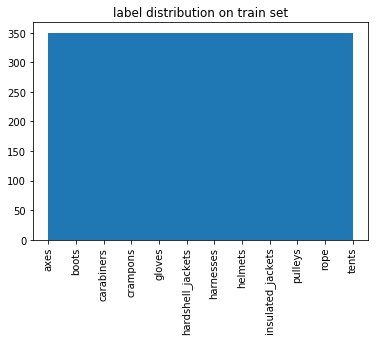

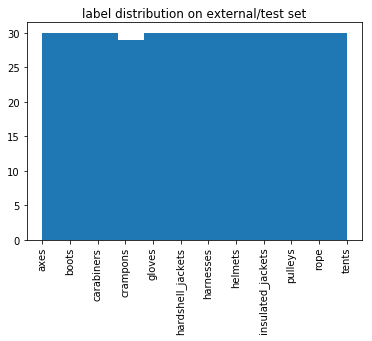

In [15]:
def labelDist(y, title):
    plt.figure()
    plt.hist(y,bins=12)
    plt.title(title)
    plt.xticks(range(12),imageTypes.keys(), rotation='vertical')
    
labelDist(y_train_bal, title="label distribution on train set")
labelDist(y_test, title="label distribution on external/test set")

Now, let's plot the average image again. This looks a little bit more reasonable i.e. there is a consistent "contribution" to the mixture from all 12 classes. If anything it's now the rope which is slightly dominating, I assume because its being "boosted" from mixing with the jackets which entirely intersect. 

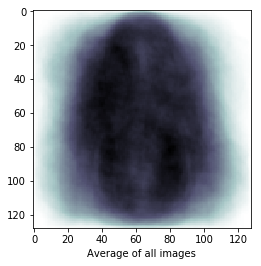

In [16]:
PlotAverageImage(X_train_bal)

Let's look at the intensity histogram for each class average on the train set. This is interesting;


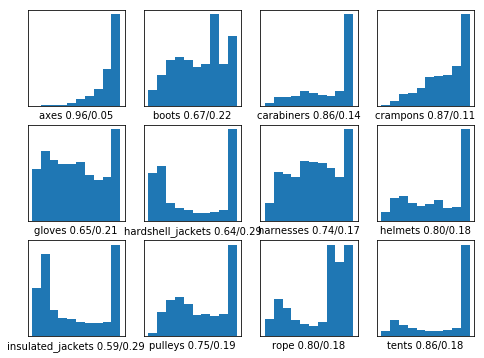

In [39]:
fig = plt.figure(figsize=(8, 6))
# plot several images
i = 0
for key in imageTypes.keys():
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    x = X[y==imageTypes[key]].mean(axis=0).flatten()
    ax.hist(x)
    ax.set_xlabel( f"{key} {x.mean():.2f}/{x.std():.2f}" ) 
    i = i + 1

One of the key goals in vision, is transforming the data out of the space domain. In the olden days of computer vision, the onus was on the data scientists themselves to transform the data out of the space domain using some feature. This histogram technique is the most basic version of that. 


* Classical algorithms can not learn any spatial relationship or local pattern between the pixels and the assumption is that images are typically taken from a variety of angles/environments which *should* render pixel-by-pixel mapping methods unworkable. 
* Images are sparse and statistically undescriptive
* We experience the "curse of dimensionality" problem working with images on classical methods


Let's look at these histograms; while there are some differences between the classes, clearly the previous (2d spatial) information is more instructive to seperate the class. We can tell this just with visual inspection. Let's close the loop on this one though and build a classifier using these histograms as feature vectors. 

In [40]:
def getHistFeatures(D, bins=20):
    
    n = D.shape[0]
    
    Xf = D.reshape(n,128*128)
    
    x = np.zeros( (n, bins))
    
    for i in range( n ):
        hist, _ = np.histogram(Xf[i], bins=bins)
        
        x[i] = hist
        
    x = x / np.max(np.max(x))
    
    return x

bins = 20
Xh_train_bal = getHistFeatures(X_train_bal, bins=bins)
Xh_val = getHistFeatures(X_val, bins=bins)
Xh_test = getHistFeatures(X_test, bins=bins)

print(Xh_train_bal.shape, Xh_val.shape, Xh_test.shape)

(4200, 20) (531, 20) (359, 20)


Basic Trees algorithm (ID3) function

In [41]:
from sklearn import tree
from sklearn import metrics

def flattenImage(I, dim=128):
    if len(I.shape)>3:
        return I.reshape(I.shape[0], dim*dim, 3)
    else:
        return I.reshape(I.shape[0], dim*dim)

# expects flattened data going in
def ID3(xtr,xte,ytr,yte, title="confusion"):
    print(title)
    classifier = tree.DecisionTreeClassifier()
    clf = classifier.fit(xtr, ytr)
    p = clf.predict(xte)
    print(
        metrics.classification_report(
            ConvertIndexToLabel(yte), 
            ConvertIndexToLabel(p)
        ))
    plotConfusion(yte, p, title=title)
    return p, clf


So we have now transformed our (1591, 128, 128) image data into (1591, 20) i.e. instead of $128^2$ pixel values, we have $20$ discrete bins of intensity values. We have also scaled the data $\in [0,1]$ Let's run ID3 (trees) and see what we get

Trees intensity histogram features (validation)

                   precision    recall  f1-score   support

             axes       0.90      1.00      0.95        28
            boots       0.42      0.36      0.39        22
       carabiners       0.59      0.81      0.68        63
         crampons       0.75      0.47      0.58        38
           gloves       0.45      0.35      0.40        51
hardshell_jackets       0.55      0.72      0.62       106
        harnesses       0.67      0.73      0.70        45
          helmets       0.38      0.46      0.42        24
insulated_jackets       0.61      0.37      0.46        68
          pulleys       0.25      0.14      0.18        14
             rope       0.59      0.67      0.63        43
            tents       0.56      0.31      0.40        29

      avg / total       0.58      0.58      0.57       531

Trees intensity histogram features (test)

                   precision    recall  f1-score   support

             axes  

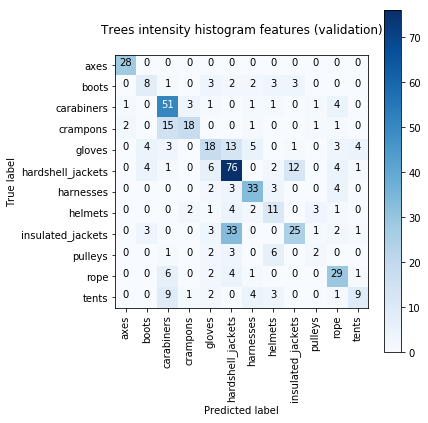

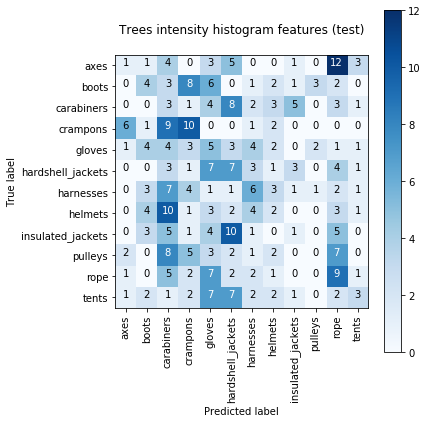

In [42]:
%%time
ID3( Xh_train_bal, Xh_val, y_train_bal, y_val, title='Trees intensity histogram features (validation)\n' )
ID3( Xh_train_bal, Xh_test, y_train_bal, y_test, title='Trees intensity histogram features (test)\n' )

Surprisingly, this isn't too bad on the validation set! Clearly though we lose a lot of information by transforming out of the space domain in this way. On the test set i.e. the real world dataset, the results are shockingly poor

Let's run a basic decision tree algorithm on the images (balanced train set) on the **raw pixels** i.e. ID3 algorithm

Trees on balanced train set, unbalanced validation set
                   precision    recall  f1-score   support

             axes       0.81      0.79      0.80        28
            boots       0.82      0.82      0.82        22
       carabiners       0.82      0.81      0.82        63
         crampons       0.95      0.50      0.66        38
           gloves       0.52      0.43      0.47        51
hardshell_jackets       0.60      0.75      0.67       106
        harnesses       0.69      0.69      0.69        45
          helmets       0.58      0.75      0.65        24
insulated_jackets       0.56      0.34      0.42        68
          pulleys       0.08      0.07      0.08        14
             rope       0.55      0.84      0.66        43
            tents       0.83      0.83      0.83        29

      avg / total       0.66      0.65      0.64       531

Trees on balanced train set, test set
                   precision    recall  f1-score   support

             axes 

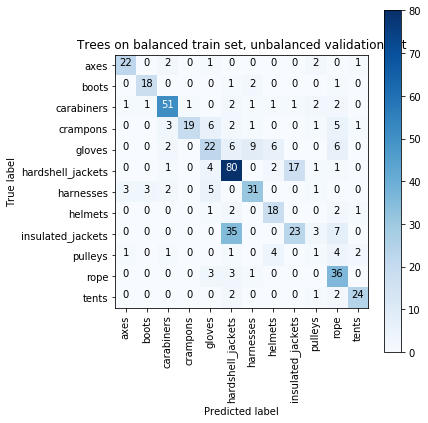

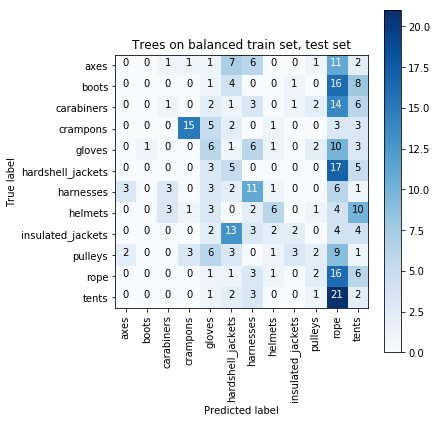

In [43]:
%%time
ID3( 
    flattenImage(X_train_bal), 
    flattenImage(X_val), 
    y_train_bal, 
    y_val, 
    title='Trees on balanced train set, unbalanced validation set' )

ID3( 
    flattenImage(X_train_bal), 
    flattenImage(X_test), 
    y_train_bal, 
    y_test, 
    title='Trees on balanced train set, test set' )

We get about ~.61 f-1 on validation which to be clear is training on the supersampled train split and tested on the original validation and test splits. The confusion matrix; clearly the biggest problem is confusing the two jacket classes (validation). But surprisingly, this isn't too bad either. It is better to model the raw pixels right now than the histogram features. On the real world test split however, the results are shockingly bad. We are getting slightly better than guessing and it's predicting everything as ropes!

Take home message should be developing here; using classical algorithms on image data isn't a smart thing to do -- especially if you are modelling the raw pixels!

Other approaches work to try and transform out of the larger, sparse space domain while retaining some spatial information. An example of this is histogram of gradients (HoG) 

(8100,)


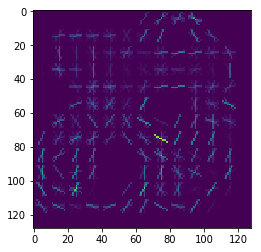

In [22]:
from skimage.feature import hog

fd, hogimage = hog(X_train_bal[30], block_norm='L2-Hys', visualise=True, cells_per_block=(10,10), pixels_per_cell=(10,10))

plt.imshow(hogimage)

print(fd.shape)

In [23]:
%%time

def computeHogFeatures(x):
    n = x.shape[0]
    
    Xhog = np.zeros( (n, 8100) )

    for i in range(n):
        Xhog[i] = hog(x[i], block_norm='L2-Hys', cells_per_block=(10,10), pixels_per_cell=(10,10))
        
    return Xhog

X_train_bal_hog = computeHogFeatures(X_train_bal)
X_test_bal_hog = computeHogFeatures(X_test)

Wall time: 9.83 s


SVM reusable function;

In [44]:
from sklearn import svm
    
def SVM(xtr, xte, ytr, yte, title="confusion matrix", C=10., gamma=0.001):
    print(title)
    clf = svm.SVC(C=C, kernel='rbf', gamma=gamma)
    clf.fit(xtr, ytr)
    y_pred = clf.predict(xte)
    print(metrics.classification_report(ConvertIndexToLabel(yte), ConvertIndexToLabel(y_pred)))
    plotConfusion(yte, y_pred, title=title)
    return y_pred, clf

Now let's run an SVM on the hog features (turns out this is actually really bad, PCA didn't help)

Note that "Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples." means that some examples didn't even get a prediction at all

SVM HOG test



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.43      0.20      0.27        30
       carabiners       0.30      0.10      0.15        30
         crampons       0.20      0.76      0.31        29
           gloves       0.24      0.40      0.30        30
hardshell_jackets       0.29      0.17      0.21        30
        harnesses       0.39      0.50      0.44        30
          helmets       0.67      0.27      0.38        30
insulated_jackets       0.83      0.50      0.62        30
          pulleys       1.00      0.17      0.29        30
             rope       0.15      0.33      0.20        30
            tents       0.47      0.23      0.31        30

      avg / total       0.41      0.30      0.29       359

Wall time: 26.5 s


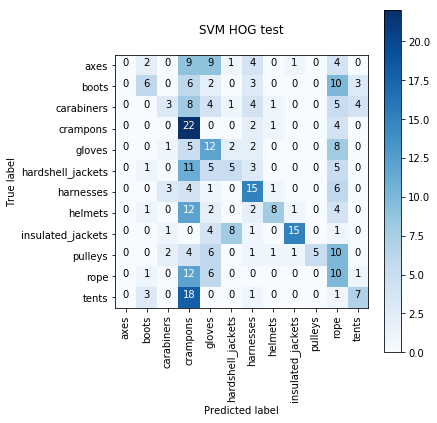

In [25]:
%%time
y_pred = SVM(X_train_bal_hog, X_test_bal_hog, y_train_bal, y_test, title='SVM HOG test\n', C=25, gamma=0.001)

PCA helper function

In [45]:
from sklearn import decomposition

def PCA(xtr, xte, n_components=50, flat_size = 128*128):
    
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(xtr.reshape(xtr.shape[0],flat_size))

    xtr_pca = pca.transform(xtr.reshape(xtr.shape[0],flat_size))
    xte_pca = pca.transform(xte.reshape(xte.shape[0],flat_size))
    
    return xtr_pca, xte_pca, pca
    

Let's try PCA on the raw pixels + SVM

SVM PCA (validation)
                   precision    recall  f1-score   support

             axes       1.00      0.93      0.96        28
            boots       1.00      0.95      0.98        22
       carabiners       0.93      0.98      0.95        63
         crampons       0.89      0.89      0.89        38
           gloves       0.92      0.92      0.92        51
hardshell_jackets       0.83      0.90      0.86       106
        harnesses       1.00      0.96      0.98        45
          helmets       0.92      0.92      0.92        24
insulated_jackets       0.83      0.74      0.78        68
          pulleys       1.00      0.50      0.67        14
             rope       0.81      0.98      0.88        43
            tents       1.00      0.97      0.98        29

      avg / total       0.90      0.90      0.90       531

SVM PCA (test)


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.17      0.03      0.06        30
       carabiners       0.00      0.00      0.00        30
         crampons       0.67      0.41      0.51        29
           gloves       0.16      0.40      0.23        30
hardshell_jackets       0.15      0.17      0.16        30
        harnesses       0.48      0.37      0.42        30
          helmets       0.47      0.23      0.31        30
insulated_jackets       0.38      0.10      0.16        30
          pulleys       0.50      0.03      0.06        30
             rope       0.13      0.63      0.22        30
            tents       0.04      0.03      0.04        30

      avg / total       0.26      0.20      0.18       359

Wall time: 6.97 s


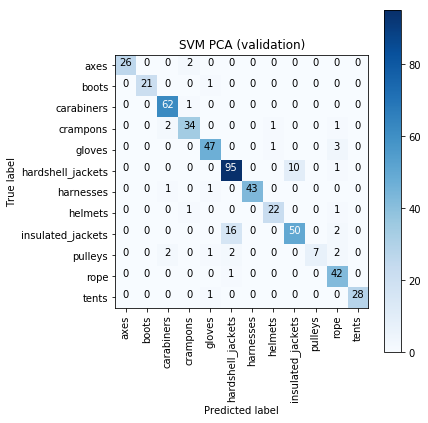

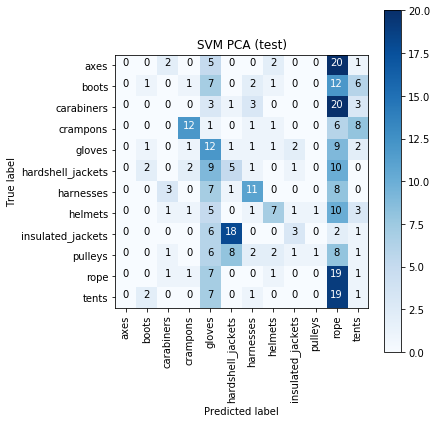

In [46]:
%%time

X_train_bal_pca, X_val_bal_pca, _ = PCA(X_train_bal, X_val, n_components=40)

y_pred, model = SVM(X_train_bal_pca, 
                    X_val_bal_pca, 
                    y_train_bal, 
                    y_val, 
                    title='SVM PCA (validation)', 
                    C=20, 
                    gamma=0.001)

X_train_bal_pca, X_test_bal_pca, _ = PCA(X_train_bal, X_test, n_components=40)

y_pred, model = SVM(X_train_bal_pca, 
                    X_test_bal_pca, 
                    y_train_bal, 
                    y_test, 
                    title='SVM PCA (test)', 
                    C=20, 
                    gamma=0.001)



This is instructive. On validation it looks like we just build an amazing classifier (f1 0.9), but in the real-world test dataset it performs shockingly badly (0.18).

On the real-world datasets it seems to love classifying everything as rope! Let's take a look at that class and see what's going on?

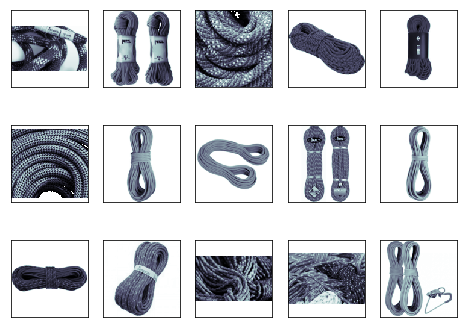

In [47]:
plotSome(X_test, y_test, name="rope")

Now let's add some white noise to the backgrounds, the hypothesis on the table is that it's just learning where the white pixels are to perform so well on the validation set

In [48]:
%%time

from random import uniform
from pipe import take, select, as_list, Pipe

import random

@Pipe
def pshuffle(l):
    random.shuffle(l)
    return l

def noiseImages( images ):
    
    images_whitenoise = images.copy()

    mask = images_whitenoise>0.95
    vals = range(np.count_nonzero(mask)) | select( lambda n: uniform(0, 1)) | as_list()

    # Assign back into X
    images_whitenoise[mask] = vals
    return images_whitenoise

X_val_whitenoise = noiseImages( X_val )
X_train_bal_whitenoise = noiseImages( X_train_bal )

Wall time: 24.7 s


And let's plot 16 test images to see if the backgrounds have been noised

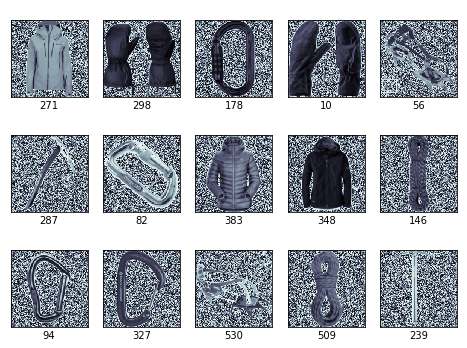

In [49]:
plot16(X_val_whitenoise, rand=True)

Now let's run trees (ID3) on noisy images, we are expecting the accuracy to plummet

In [50]:
print(X_train_bal_whitenoise.shape, X_val_whitenoise.shape, y_train_bal.shape, y_test.shape)

(4200, 128, 128) (531, 128, 128) (4200,) (359,)


Confusion on unbal val split with white noise added
                   precision    recall  f1-score   support

             axes       0.15      0.25      0.19        28
            boots       0.29      0.45      0.36        22
       carabiners       0.25      0.21      0.23        63
         crampons       0.33      0.29      0.31        38
           gloves       0.31      0.31      0.31        51
hardshell_jackets       0.51      0.54      0.53       106
        harnesses       0.27      0.29      0.28        45
          helmets       0.30      0.50      0.37        24
insulated_jackets       0.54      0.29      0.38        68
          pulleys       0.33      0.07      0.12        14
             rope       0.38      0.35      0.37        43
            tents       0.19      0.24      0.22        29

      avg / total       0.36      0.34      0.34       531

Wall time: 1min 7s


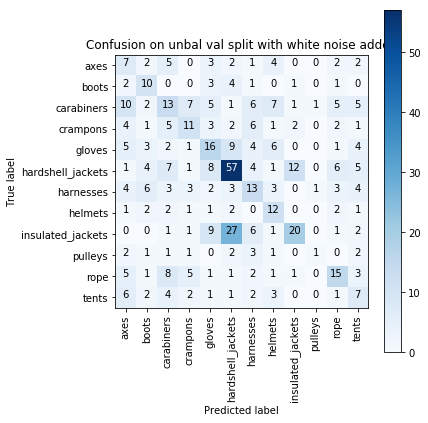

In [51]:
%%time

preds = ID3(flattenImage(X_train_bal_whitenoise), 
             flattenImage(X_val_whitenoise), 
             y_train_bal, y_val, title='Confusion on unbal val split with white noise added')

And indeed, the accuracy plumets to ~.34 average f-1 score!! Ouch.

It's now shockingly bad on axes, helmets and pulleys, let's look at the confusion matrix. This means we can surmise to some extent that the previous model was overfitting the whitespace

Pretty bad across the board but what we do see is that hardshell jackets dominate in the confusion matrix! This is pretty much because we have more hardshell jackets than any other class in the validation set which means that the confusion matrix is not instructive. Note that the f-1 scores are normalised by the "rate" i.e. are agnostic to class imbalance.  We can;

* Supersample the validation set so that the label distribution is balanced like the training set, this would result in many duplicate images
* Subsample the val set so that the label distribution is balanced, this would result in a much smaller set
* Supersample the val set with augmentation i.e. random translations, scale/rotation transforms (maybe even affine). 

There are tradeoffs here. The first option will effectively be testing over many of the same images. The second option would result in a much smaller sample. The third option is safer but would destroy classical methods even faster which perform pixel mapping. We want to do augmentation anyway soon to demonstrate this. 

First, let's supersample the val set and renoise, and see what we get

ID3 raw pixels noise, balanced val
                   precision    recall  f1-score   support

             axes       0.19      0.17      0.18       100
            boots       0.31      0.36      0.33       100
       carabiners       0.18      0.25      0.21       100
         crampons       0.31      0.28      0.29       100
           gloves       0.33      0.32      0.32       100
hardshell_jackets       0.35      0.54      0.42       100
        harnesses       0.18      0.21      0.19       100
          helmets       0.39      0.32      0.35       100
insulated_jackets       0.41      0.23      0.29       100
          pulleys       0.00      0.00      0.00       100
             rope       0.33      0.44      0.38       100
            tents       0.30      0.33      0.31       100

      avg / total       0.27      0.29      0.27      1200

Wall time: 1min 14s


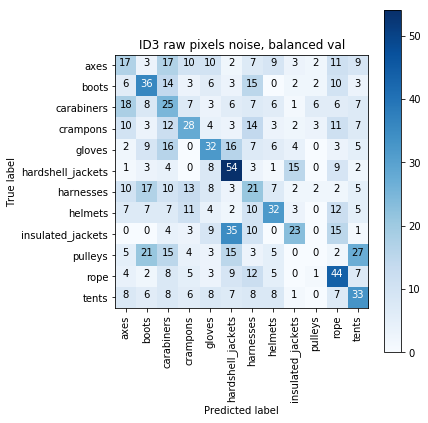

In [52]:
%%time
data = balancedSignalGenerator(X_val,y_val) | take(1200) | as_list

X_val_bal = data | select(lambda el: el[1])  | as_list | as_npy
y_val_bal = data | select(lambda el: el[0])  | as_list | as_npy

X_val_bal_whitenoise = noiseImages( X_val_bal )

y_pred = ID3(flattenImage(X_train_bal_whitenoise), 
                     flattenImage(X_val_bal_whitenoise), y_train_bal, y_val_bal, title="ID3 raw pixels noise, balanced val")

This is interesting, so the F-1 score is similar but the results are way more balanced i.e. the confusion matrix is telling a much better story and we can actually intepret what is being confused with what and suffice to say, there is a lot of confusion going on ;)

There is a problem in classical ML approaches called the *Curse of Dimensionality* where classifiers tend to overfit the training data in high dimensional spaces, especially when there are more dimensions as there are examples. Deep learning doesn't suffer from this problem because the data is usually larger, and that deep learning algorithms learn a lower dimensional intermediate representation as part of the training process which might have different activations for sparse patterns in the input data and also learn a spatial manifold to transform the data. 

SVM transforms the data into an implied higher dimensional (infinite in the case of RBF kernel i.e. kernel hilbert space see https://en.wikipedia.org/wiki/Mercer%27s_theorem) space by computing the $N \times N$ $XX'$ matrix i.e. where $N$ is the number of examples. This means that the space complexity is a function of $N$, not $L$ (the number of attributes). Of course in this situation, $L$ is still $~2200$ which means we have about $5$ million bytes. You might think that SVMs would be more prone to the curse of dimensionality, but actually this is not true. 

"The SVM is an approximate implementation of a bound on the generalization error, that depends on the margin (essentially the distance from the decision boundary to the nearest pattern from each class), but is independent of the dimensionality of the feature space." https://stats.stackexchange.com/questions/35276/svm-overfitting-curse-of-dimensionality

In classical ML, the more features you add past a point, the worse the performance gets;

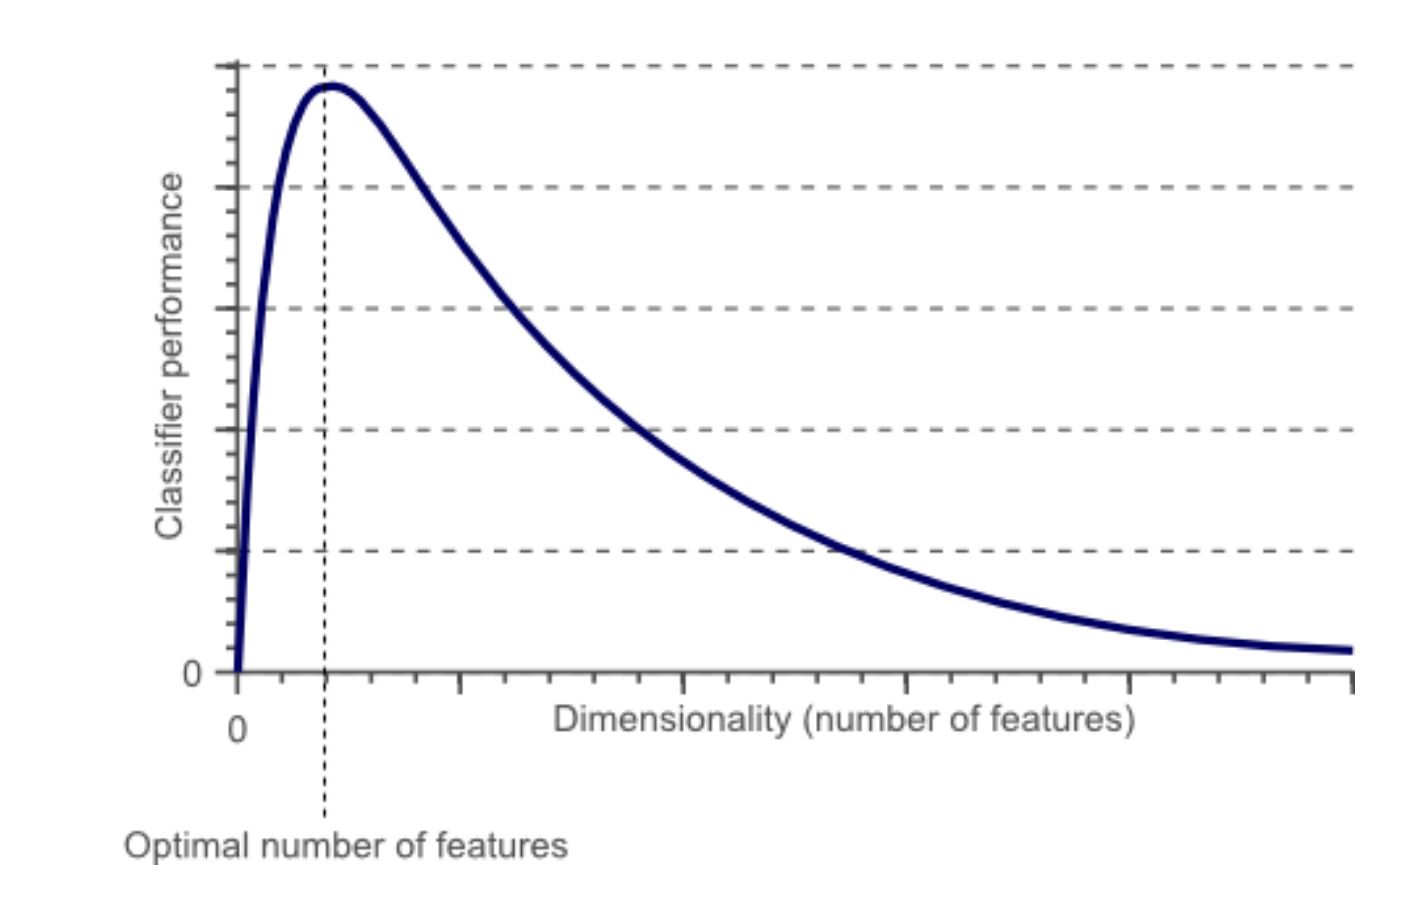

(image from http://www.visiondummy.com/2014/05/feature-extraction-using-pca/#PCA_pitfalls)

Of course, in this application every single pixel is a feature, which means we have $128^2$ features which is $\gt10000$! It means we have significantly more features than we do signals. 

An approach people use in these circumstances with classical algorithms is to use PCA to reduce the dimensionality first. 

Signals are often redundant because they are statistically dependent (correlated). PCA transforms the data into a set of uncorrelated components, allowing you to focus on the most significant components without losing any information about them. 

PCA computes the eigen vectors of the covariance matrix of $X$ and then projects the data onto those vectors. This still makes some assumption about the absolute pixel positions of images i.e. if they are all shifted, there would be less correlation between the dimensions. PCA is good because it;

* Captures the correlation if there is any and projects into decorrelated features
* Removes noise
* Helps with the curse of dimensionality

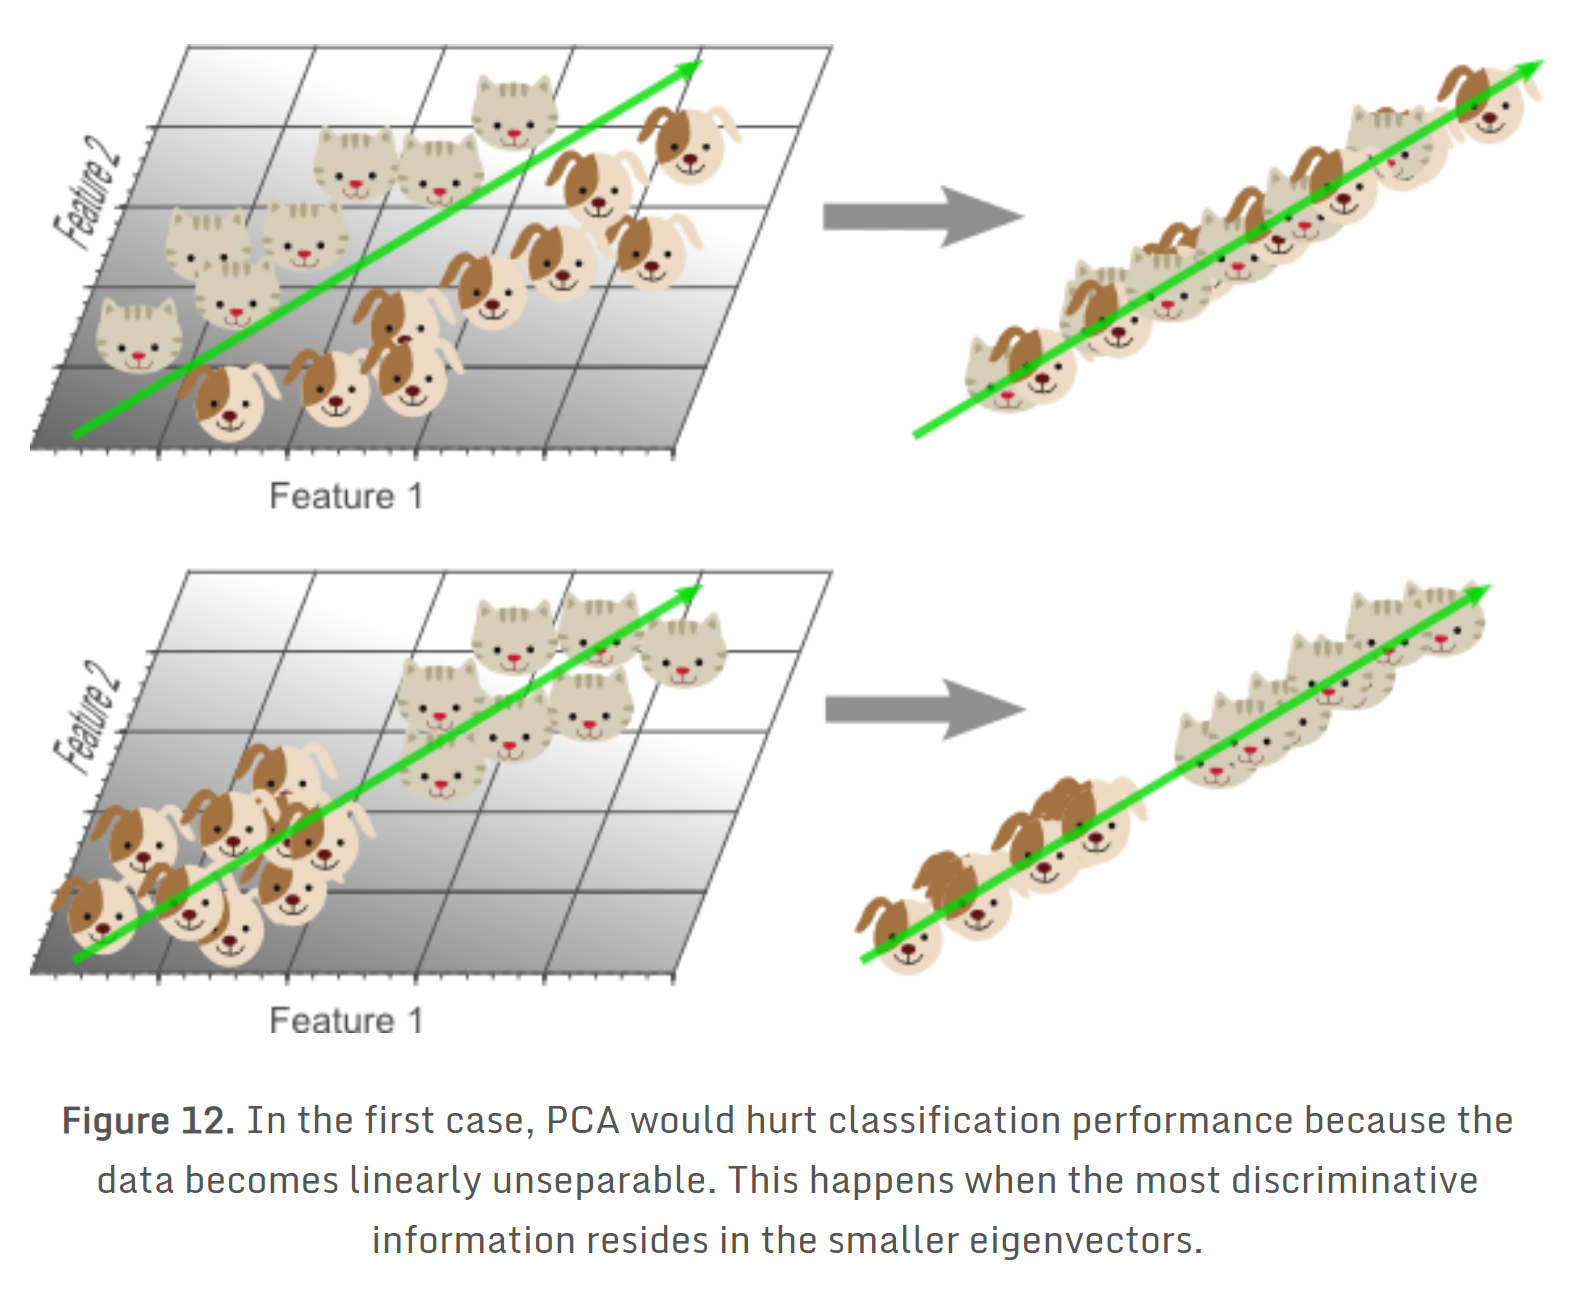




In this case, other dimensionality reduction methods might be of interest, such as Linear Discriminant Analysis (LDA) which tries to find the projection vector that optimally separates the two classes.

PCA would clearly help here because all the images are scaled and frontalised the same. So in that sense it actually helps "transforming the data out of the space domain" by learning correlations between pixels fixed in space. If the images were "all over the place" and subject to random transformations (augmentations); PCA would only help in this respect where there was some accidental consistency of overlap.

In [53]:
X_train_bal_whitenoise_pca, X_val_bal_whitenoise_pca, pca = PCA(X_train_bal_whitenoise, X_val_bal_whitenoise)

Let's visualise the first principal components

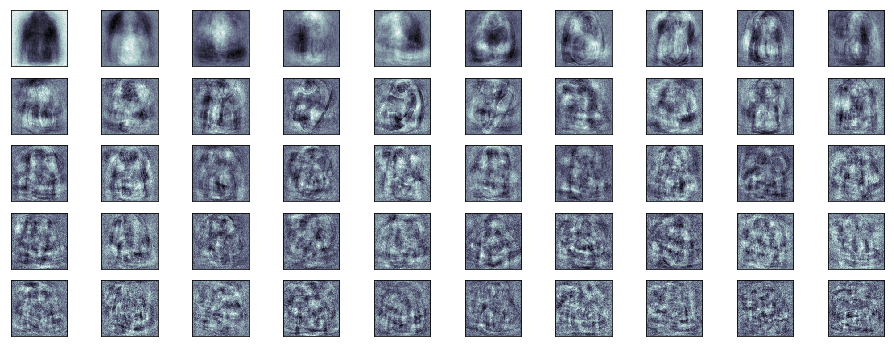

In [35]:
fig = plt.figure(figsize=(16, 6))
for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(128,128),
              cmap=plt.cm.bone)

What we observe here is that the principal component do not magically transform the data out of the space domain -- the x/y dimensions are still highly relevant. But it does show us something about the variance between pixels accross classes i.e. we can start to see the shapes of different items

Now that we have only 50 features, it's computationally tractable to run something like an SVM, let's try that

Let's try running an SVM on the PCA data

Let's use the PCA projection vectors learned from the whitenoise train split to transform the external test data and see if we get any traction on that.

white noise + PCA + balanced validation
                   precision    recall  f1-score   support

             axes       0.51      0.97      0.67       100
            boots       0.88      0.91      0.90       100
       carabiners       0.48      0.69      0.57       100
         crampons       0.90      0.57      0.70       100
           gloves       0.78      0.80      0.79       100
hardshell_jackets       0.58      0.86      0.69       100
        harnesses       0.94      0.64      0.76       100
          helmets       0.88      0.82      0.85       100
insulated_jackets       0.83      0.57      0.67       100
          pulleys       1.00      0.14      0.25       100
             rope       0.65      0.77      0.71       100
            tents       0.80      0.70      0.74       100

      avg / total       0.77      0.70      0.69      1200

white noise + PCA + balanced test/external


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.00      0.00      0.00        30
       carabiners       0.75      0.10      0.18        30
         crampons       0.00      0.00      0.00        29
           gloves       0.04      0.03      0.04        30
hardshell_jackets       0.00      0.00      0.00        30
        harnesses       0.17      0.07      0.10        30
          helmets       0.00      0.00      0.00        30
insulated_jackets       0.33      0.03      0.06        30
          pulleys       0.07      0.73      0.13        30
             rope       0.00      0.00      0.00        30
            tents       0.00      0.00      0.00        30

      avg / total       0.11      0.08      0.04       359

Wall time: 1.42 s


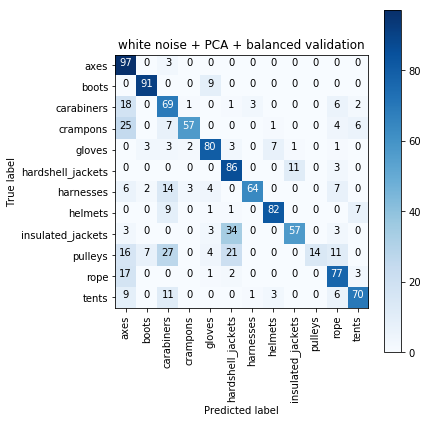

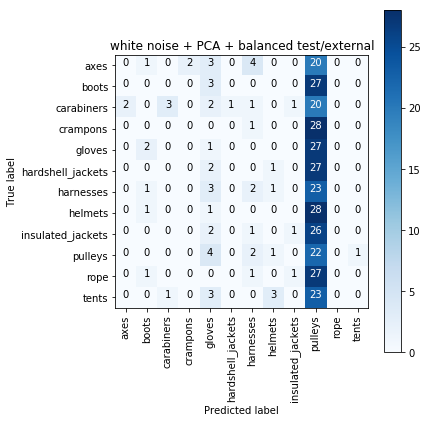

In [54]:
%%time
y_pred = SVM(X_train_bal_whitenoise_pca, 
             X_val_bal_whitenoise_pca, 
             y_train_bal, 
             y_val_bal, 
             title="white noise + PCA + balanced validation")

X_test_pca = pca.transform(X_test.reshape(359, 128*128))

y_pred = SVM(X_train_bal_whitenoise_pca, 
             X_test_pca, 
             y_train_bal, 
             y_test, 
             title="white noise + PCA + balanced test/external")



The performance drops from .9 to .68, the whitespace was clearly helping the classifier before. Lots of things seem to be classified as axes incorrectly

When we project the external test data using the same PCA projection vectors, the results are shocking -- clearly this is an approach that participants might think is a good idea but is a disaster in practice 

The hypothesis on the table is that a CNN would work better because it can model local spatial patterns which are somewhat invariant to translation

First to use a CNN we need to add an explicit colour channel back in, even if it's only 1, also we need to one-hot encode the labels

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

def addColourDimension(x):
    return x.reshape(x.shape[0],128,128,1)

def plotHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
def runCNNModel( xtr, xte, ytr, yte, epochs=5, batchsize=100, dropout=0.4 ):
    
    xtr_1 = addColourDimension(xtr)
    xte_1 = addColourDimension(xte)
    ytr_1 = to_categorical(ytr, num_classes=12)
    yte_1 = to_categorical(yte, num_classes=12)
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(12, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [ EarlyStopping(
        monitor='val_acc', 
        min_delta=0, 
        patience=10, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        # this will restore the best weights back to the model
        restore_best_weights=True) ]
    
    #train the model
    history = model.fit(xtr_1, ytr_1, 
                        epochs=epochs, batch_size=batchsize, 
                        validation_data=(xte_1, yte_1),
                        callbacks=callbacks, verbose=1)
    
    plotHistory(history)
    
    return history, model


Train on 4200 samples, validate on 1200 samples
Epoch 1/30
4200/4200 [==============================] - 2s 540us/step - loss: 1.4556 - acc: 0.5469 - val_loss: 0.6550 - val_acc: 0.7967
Epoch 2/30
4200/4200 [==============================] - 2s 358us/step - loss: 0.4831 - acc: 0.8352 - val_loss: 0.3940 - val_acc: 0.8358
Epoch 3/30
4200/4200 [==============================] - 1s 356us/step - loss: 0.2769 - acc: 0.9043 - val_loss: 0.3051 - val_acc: 0.8883
Epoch 4/30
4200/4200 [==============================] - 1s 355us/step - loss: 0.1797 - acc: 0.9400 - val_loss: 0.3164 - val_acc: 0.9000
Epoch 5/30
4200/4200 [==============================] - 2s 359us/step - loss: 0.1319 - acc: 0.9550 - val_loss: 0.3223 - val_acc: 0.8767
Epoch 6/30
4200/4200 [==============================] - 1s 357us/step - loss: 0.1142 - acc: 0.9569 - val_loss: 0.2703 - val_acc: 0.8875
Epoch 7/30
4200/4200 [==============================] - 1s 356us/step - loss: 0.0939 - acc: 0.9667 - val_loss: 0.2460 - val_acc: 0.9067


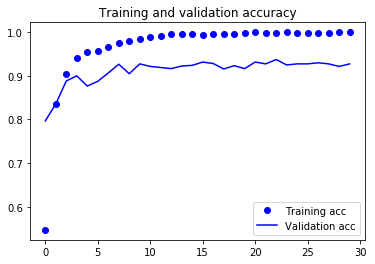

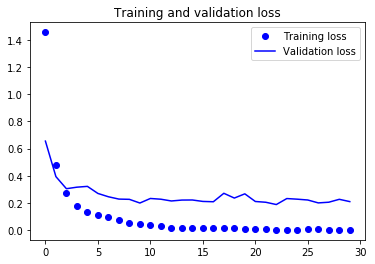

In [82]:
history, model_noise = runCNNModel(
    X_train_bal_whitenoise,
    X_val_bal_whitenoise,
    y_train_bal,
    y_val_bal, epochs=30, batchsize=200, dropout=0.6)

                   precision    recall  f1-score   support

             axes       0.98      1.00      0.99       100
            boots       1.00      0.91      0.95       100
       carabiners       0.98      0.94      0.96       100
         crampons       0.96      0.98      0.97       100
           gloves       0.78      0.92      0.84       100
hardshell_jackets       0.83      0.95      0.89       100
        harnesses       1.00      0.98      0.99       100
          helmets       1.00      1.00      1.00       100
insulated_jackets       0.91      0.92      0.92       100
          pulleys       1.00      0.71      0.83       100
             rope       0.88      0.99      0.93       100
            tents       1.00      0.95      0.97       100

      avg / total       0.94      0.94      0.94      1200



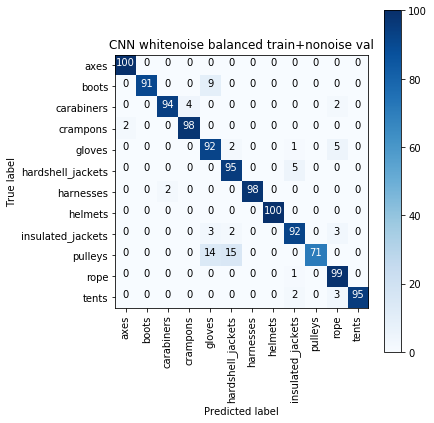

In [64]:
from numpy import argmax

def CNNEvaluate(model, xte,yte,title=''):
    y_pred = model.predict(addColourDimension(xte))
    print(metrics.classification_report(ConvertIndexToLabel(yte), ConvertIndexToLabel(argmax(y_pred,axis=1))))
    plotConfusion(yte, argmax(y_pred,axis=1), title=title)

CNNEvaluate(model_noise,X_val_bal_whitenoise,y_val_bal, title='CNN whitenoise balanced train+nonoise val')

Wow! On the validation data -- the CNN is getting a pretty much perfect score -- even with the noise added! 

The CNN on the balanced noisy data works very well indeed - almost a perfect result, demonstrating the power of being able to learn invariant spatial features between pixels. The best classical approach was .69f1 and this improves it significantly to .94f1

And if we run it against the external test population?

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.00      0.00      0.00        30
       carabiners       0.00      0.00      0.00        30
         crampons       0.00      0.00      0.00        29
           gloves       0.29      0.07      0.11        30
hardshell_jackets       0.00      0.00      0.00        30
        harnesses       0.00      0.00      0.00        30
          helmets       0.00      0.00      0.00        30
insulated_jackets       0.00      0.00      0.00        30
          pulleys       0.67      0.07      0.12        30
             rope       0.09      1.00      0.16        30
            tents       0.00      0.00      0.00        30

      avg / total       0.09      0.09      0.03       359



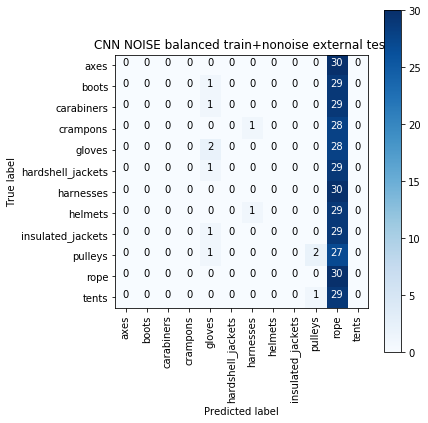

In [66]:
CNNEvaluate(model_noise,X_test,y_test, title='CNN NOISE balanced train+nonoise external test')

Oh dear! This should be a clue of something, with the noise the CNN doesn't generalise AT ALL to test!

What if we run the CNN on the pre-noise data?

Train on 4200 samples, validate on 1200 samples
Epoch 1/30
4200/4200 [==============================] - 2s 494us/step - loss: 1.5546 - acc: 0.5302 - val_loss: 0.7197 - val_acc: 0.7567
Epoch 2/30
4200/4200 [==============================] - 1s 355us/step - loss: 0.4628 - acc: 0.8514 - val_loss: 0.3861 - val_acc: 0.8758
Epoch 3/30
4200/4200 [==============================] - 1s 356us/step - loss: 0.2108 - acc: 0.9329 - val_loss: 0.3427 - val_acc: 0.8883
Epoch 4/30
4200/4200 [==============================] - 1s 354us/step - loss: 0.1257 - acc: 0.9595 - val_loss: 0.3314 - val_acc: 0.8783
Epoch 5/30
4200/4200 [==============================] - 1s 355us/step - loss: 0.0930 - acc: 0.9681 - val_loss: 0.2897 - val_acc: 0.9092
Epoch 6/30
4200/4200 [==============================] - 1s 355us/step - loss: 0.0784 - acc: 0.9738 - val_loss: 0.2969 - val_acc: 0.9150
Epoch 7/30
4200/4200 [==============================] - 1s 355us/step - loss: 0.0471 - acc: 0.9864 - val_loss: 0.2631 - val_acc: 0.9158


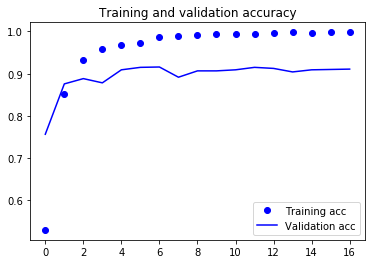

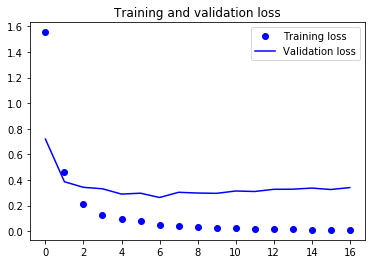

In [68]:
history, model_nonoise = runCNNModel(
    X_train_bal,
    X_val_bal,
    y_train_bal,
    y_val_bal, epochs=30, batchsize=200, dropout=0.6)

                   precision    recall  f1-score   support

             axes       0.50      0.03      0.06        30
            boots       0.07      0.03      0.05        30
       carabiners       0.25      0.07      0.11        30
         crampons       0.33      0.76      0.46        29
           gloves       0.21      0.23      0.22        30
hardshell_jackets       0.20      0.13      0.16        30
        harnesses       0.50      0.50      0.50        30
          helmets       0.37      0.23      0.29        30
insulated_jackets       0.50      0.27      0.35        30
          pulleys       0.71      0.17      0.27        30
             rope       0.12      0.47      0.19        30
            tents       0.08      0.07      0.07        30

      avg / total       0.32      0.25      0.23       359



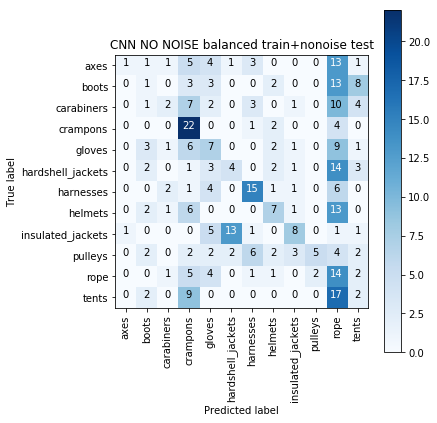

In [69]:
CNNEvaluate(model_nonoise,X_test,y_test, title='CNN NO NOISE balanced train+nonoise test')

What's interesting here is that the white noise **hardly affected CNN** at all on validation performance, but totally destroyed it on the test performance. This is a clue that the CNN was actually learning the noise which is the opposite of what we wanted it to do. 

Now we are going to simulate a real-world scenario and apply random mutations to the images before splitting and training

First we use some boilerplate code to handle the augmentation

We will select out 20000 images which is the upper limit of what you could expect to use on a classical algorithm but enough to allow the CNN to learn well in respect of the augmentation

In [71]:
%%time

import random

from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=0.5,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     fill_mode="constant",
                     cval=1)

image_datagen = ImageDataGenerator(**data_gen_args)

@Pipe
def augmentation(flow):

    for x in flow:
        trans = image_datagen.get_random_transform( (128,128) )
        yield ( x[0], image_datagen
                       .apply_transform(
                           x[1].reshape(128,128,1), trans
                        ).reshape(128,128) )

augmented_flow = balancedSignalGenerator(X,y) | augmentation | take(20000) | as_list

X_bal_aug = augmented_flow | select(lambda el: el[1]) | as_list | as_npy
y_bal_aug = augmented_flow | select(lambda el: el[0]) | as_list | as_npy

X_bal_aug_noise = noiseImages(X_bal_aug)

Wall time: 2min 20s


Let's see what the results are

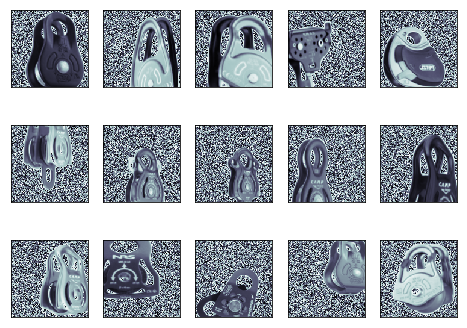

In [72]:
plotSome(X_bal_aug_noise, y_bal_aug, name="pulleys")

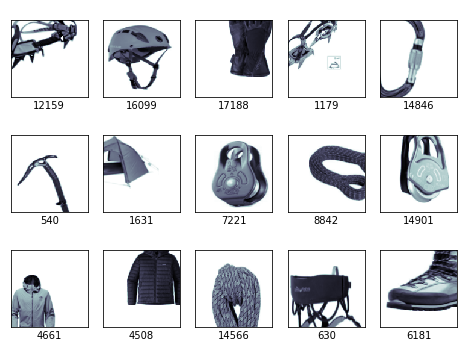

In [76]:
plot16(X_bal_aug, rand=True)

OK, we have a pretty cool dataset here now - which resembles real life conditions. The hypothesis on the table is that the trees algorithm gets near to zero accuracy, Let's see.

First let's split the data. Note that now we are augmenting, it's no longer cheating to split *after* the augmenting because we can think of them as being unique images i.e. the same thing from a different angle

In [79]:
%%time

from sklearn.model_selection import train_test_split

X_train_bal_aug_noise, X_test_bal_aug_noise, y_train_bal_aug_noise, y_test_bal_aug_noise \
    = train_test_split(X_bal_aug_noise, y_bal_aug, random_state=0)

X_train_bal_aug, X_test_bal_aug, y_train_bal_aug, y_test_bal_aug \
    = train_test_split(X_bal_aug, y_bal_aug, random_state=0)

print(X_train_bal_aug_noise.shape, X_test_bal_aug_noise.shape)
print(X_train_bal_aug.shape, X_test_bal_aug.shape)

(15000, 128, 128) (5000, 128, 128)
(15000, 128, 128) (5000, 128, 128)
Wall time: 2.77 s


                   precision    recall  f1-score   support

             axes       0.17      0.18      0.18       195
            boots       0.15      0.14      0.14       216
       carabiners       0.11      0.10      0.11       206
         crampons       0.12      0.11      0.12       213
           gloves       0.21      0.19      0.20       198
hardshell_jackets       0.21      0.20      0.21       211
        harnesses       0.07      0.08      0.08       208
          helmets       0.08      0.09      0.08       197
insulated_jackets       0.29      0.27      0.28       220
          pulleys       0.14      0.14      0.14       204
             rope       0.12      0.13      0.13       222
            tents       0.16      0.17      0.16       210

      avg / total       0.15      0.15      0.15      2500

Wall time: 3min 2s


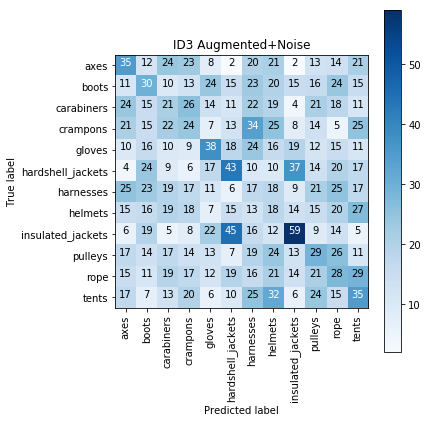

In [62]:
%%time
y_pred = ID3(
            flattenImage(X_train_bal_aug_noise), 
            flattenImage(X_test_bal_aug_noise), 
            y_train_bal_aug_noise, 
            y_test_bal_aug_noise
            )

plotConfusion(y_test_bal_aug_noise, y_pred, title='ID3 Augmented+Noise')

The next assertion is that PCA will no longer help us as the images are not aligned in space let's see

In [138]:
%%time

from sklearn import decomposition

X_train_bal_aug_hog = computeHogFeatures(X_train_bal_aug)
X_test_bal_aug_hog = computeHogFeatures(X_test_bal_aug)

X_train_bal_aug_hog_pca, X_test_bal_aug_hog_pca, pca_bal_aug_hog = \
    PCA(X_train_bal_aug_hog, X_test_bal_aug_hog, flat_size=8100)

Wall time: 1min 18s


Let's run SVM on the PCA transform from augmented+PCA (note we tried noise separatley and it was worse)

SVM Augmented+PCA
                   precision    recall  f1-score   support

             axes       0.85      0.97      0.90       397
            boots       0.95      0.94      0.95       405
       carabiners       0.96      0.90      0.93       409
         crampons       0.80      0.81      0.80       421
           gloves       0.88      0.78      0.83       427
hardshell_jackets       0.48      0.53      0.50       406
        harnesses       0.95      0.88      0.91       435
          helmets       0.83      0.89      0.86       415
insulated_jackets       0.57      0.55      0.56       428
          pulleys       0.75      0.76      0.75       429
             rope       0.76      0.73      0.75       410
            tents       0.85      0.85      0.85       418

      avg / total       0.80      0.80      0.80      5000



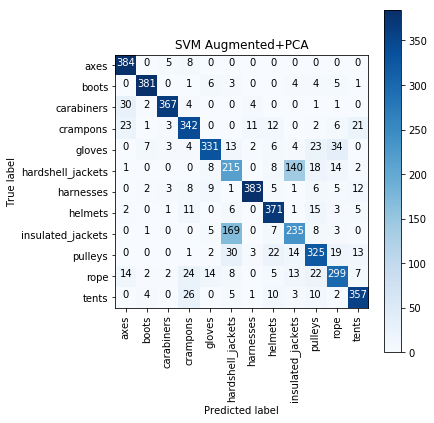

In [139]:
X_train_bal_aug_pca, X_test_bal_aug_pca, pca_bal_aug  = \
    PCA(X_train_bal_aug, X_test_bal_aug)

preds, model = SVM(
    X_train_bal_aug_pca,
    X_test_bal_aug_pca,
    y_train_bal_aug,
    y_test_bal_aug, 
    title='SVM Augmented+PCA'  )

And svm/pca on the test set

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.33      0.13      0.19        30
       carabiners       0.00      0.00      0.00        30
         crampons       0.56      0.52      0.54        29
           gloves       0.24      0.40      0.30        30
hardshell_jackets       0.22      0.20      0.21        30
        harnesses       0.36      0.40      0.38        30
          helmets       0.31      0.27      0.29        30
insulated_jackets       0.19      0.17      0.18        30
          pulleys       0.10      0.23      0.14        30
             rope       0.14      0.30      0.19        30
            tents       0.08      0.07      0.07        30

      avg / total       0.21      0.22      0.21       359



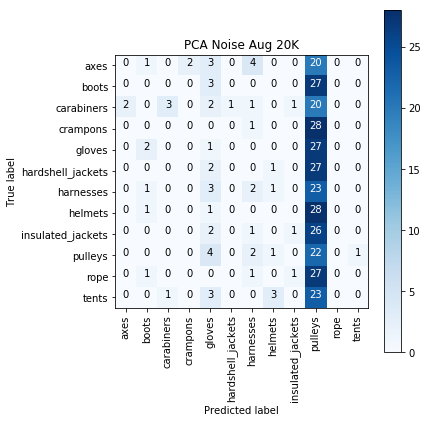

In [140]:
y_preds = model.predict( pca_bal_aug.transform( X_test.reshape(359, 128*128) ) )

print(metrics.classification_report(ConvertIndexToLabel(y_test), ConvertIndexToLabel(y_preds)))
plotConfusion(y_test, y_pred[0], title="PCA Noise Aug 20K")

Let's run SVM on the PCA transform from augmented+noise+hog

SVM Augmented+HOG+PCA
                   precision    recall  f1-score   support

             axes       0.81      0.74      0.77       397
            boots       0.59      0.76      0.67       405
       carabiners       0.60      0.71      0.65       409
         crampons       0.49      0.58      0.53       421
           gloves       0.60      0.55      0.57       427
hardshell_jackets       0.53      0.63      0.58       406
        harnesses       0.67      0.65      0.66       435
          helmets       0.46      0.47      0.47       415
insulated_jackets       0.74      0.54      0.62       428
          pulleys       0.55      0.46      0.50       429
             rope       0.60      0.54      0.57       410
            tents       0.76      0.67      0.71       418

      avg / total       0.62      0.61      0.61      5000

Wall time: 19.6 s


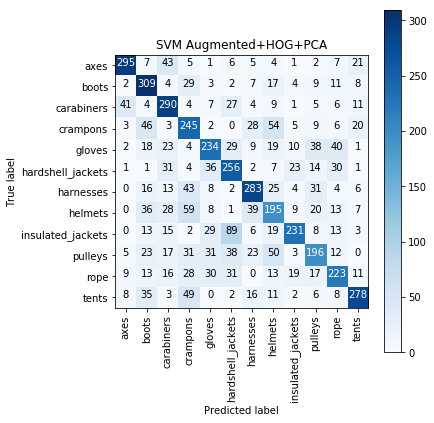

In [141]:
%%time

preds, model = SVM(
    X_train_bal_aug_hog_pca,
    X_test_bal_aug_hog_pca,
    y_train_bal_aug,
    y_test_bal_aug, 
    title='SVM Augmented+HOG+PCA'  )

And on the test set (with hog)

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.28      0.67      0.40        30
       carabiners       0.00      0.00      0.00        30
         crampons       0.35      0.59      0.44        29
           gloves       0.24      0.40      0.30        30
hardshell_jackets       0.33      0.13      0.19        30
        harnesses       0.42      0.53      0.47        30
          helmets       0.28      0.50      0.36        30
insulated_jackets       0.32      0.50      0.39        30
          pulleys       0.45      0.30      0.36        30
             rope       0.13      0.07      0.09        30
            tents       0.00      0.00      0.00        30

      avg / total       0.23      0.31      0.25       359



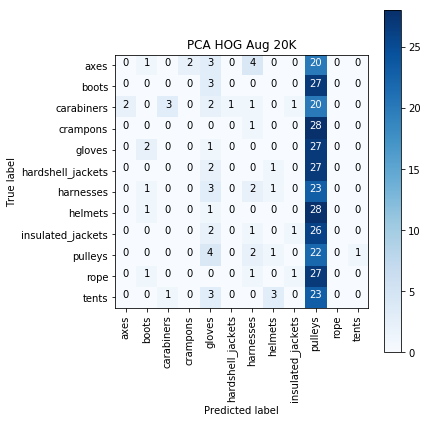

In [142]:
y_preds = model.predict( pca_bal_aug_hog.transform( computeHogFeatures( X_test ) ) )

print(metrics.classification_report(ConvertIndexToLabel(y_test), ConvertIndexToLabel(y_preds)))
plotConfusion(y_test, y_pred[0], title="PCA HOG Aug 20K")

PCA is not helping us like it did before, originally we went from about 0.28 on ID3 (trees) with balanced training labels and noise added to about .67 with PCA+SVM. Here we jump just .1 on average f-1 and as you can see from the confusion matrix it seems to think everything is axes and isn't doing well at all! It is doing well on gloves and boots and this might just be because they are not augmenting well?

Now let's try the CNN again on the augmented data, we are expecting it to be significantly better

Train on 15000 samples, validate on 1200 samples
Epoch 1/40
15000/15000 [==============================] - 6s 378us/step - loss: 2.1975 - acc: 0.2312 - val_loss: 1.4954 - val_acc: 0.4983
Epoch 2/40
15000/15000 [==============================] - 5s 322us/step - loss: 1.7215 - acc: 0.3971 - val_loss: 1.3263 - val_acc: 0.5542
Epoch 3/40
15000/15000 [==============================] - 5s 321us/step - loss: 1.5473 - acc: 0.4606 - val_loss: 1.2612 - val_acc: 0.5608
Epoch 4/40
15000/15000 [==============================] - 5s 323us/step - loss: 1.2900 - acc: 0.5651 - val_loss: 0.9075 - val_acc: 0.7058
Epoch 5/40
15000/15000 [==============================] - 5s 322us/step - loss: 1.0633 - acc: 0.6437 - val_loss: 0.8320 - val_acc: 0.7383
Epoch 6/40
15000/15000 [==============================] - 5s 322us/step - loss: 0.9331 - acc: 0.6909 - val_loss: 0.8348 - val_acc: 0.7142
Epoch 7/40
15000/15000 [==============================] - 5s 324us/step - loss: 0.8545 - acc: 0.7227 - val_loss: 0.8068 - v

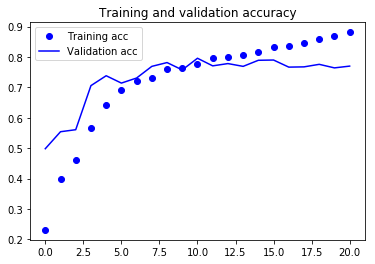

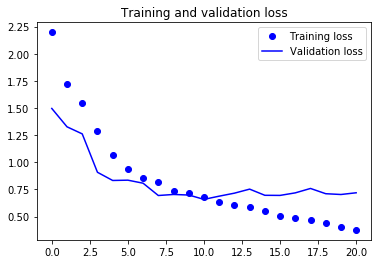

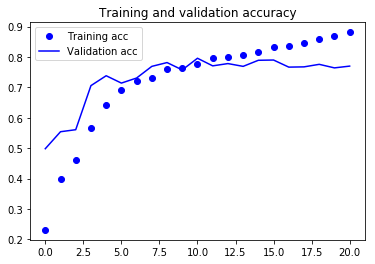

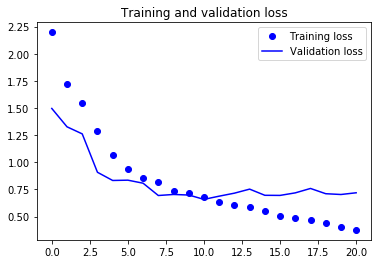

In [89]:
history, model_cnn_aug_noise = runCNNModel(
    X_train_bal_aug_noise,
    X_val_bal_whitenoise,
    y_train_bal_aug_noise,
    y_val_bal, epochs=40, batchsize=200, dropout=0.3)

plotHistory(history)

                   precision    recall  f1-score   support

             axes       0.98      0.93      0.95       100
            boots       0.93      0.89      0.91       100
       carabiners       0.88      0.83      0.86       100
         crampons       0.88      0.95      0.91       100
           gloves       0.92      0.66      0.77       100
hardshell_jackets       0.70      0.49      0.58       100
        harnesses       0.81      0.79      0.80       100
          helmets       0.92      0.93      0.93       100
insulated_jackets       0.47      0.74      0.57       100
          pulleys       0.65      0.83      0.73       100
             rope       0.76      0.65      0.70       100
            tents       0.91      0.86      0.89       100

      avg / total       0.82      0.80      0.80      1200



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.23      0.33      0.27        30
       carabiners       0.00      0.00      0.00        30
         crampons       0.00      0.00      0.00        29
           gloves       0.29      0.07      0.11        30
hardshell_jackets       0.29      0.27      0.28        30
        harnesses       0.33      0.13      0.19        30
          helmets       0.45      0.17      0.24        30
insulated_jackets       0.06      0.13      0.08        30
          pulleys       0.13      0.83      0.23        30
             rope       0.00      0.00      0.00        30
            tents       0.00      0.00      0.00        30

      avg / total       0.15      0.16      0.12       359



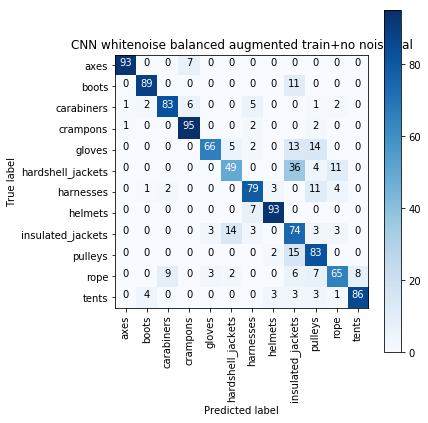

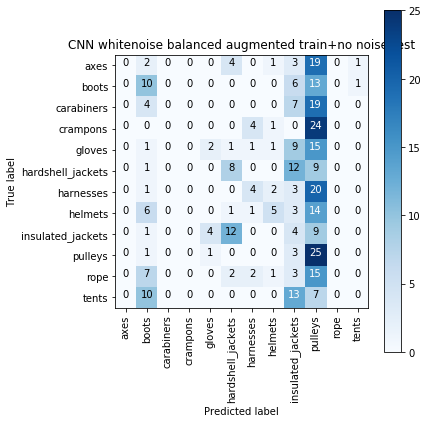

In [91]:
CNNEvaluate(model_cnn_aug_noise, 
            X_val_bal_whitenoise,
            y_val_bal, 
            title='CNN whitenoise balanced augmented train+no noise val')

CNNEvaluate(model_cnn_aug_noise, 
            X_test,
            y_test, 
            title='CNN whitenoise balanced augmented train+no noise test')

The augmented CNN achieves f1 of .80 on the augmented+noise data, a significant improvement on the .44 with augmented+noise+pca+SVM. Frankly I am extremely surprised the latter did as well as .44, I suspect if we augment more aggressively it will shoot down as we desmonstrated on the external test set. The augmented CNN with noise only achieves .12 on the external test set..

The key point here is that the noise actually make the CNN generalise to test WORSE not better. You would think that the CNN would ignore the noise, but it must have somehow lost some of its predictive power because of it

Let's do the augmented CNN with NO NOISE

Train on 15000 samples, validate on 1200 samples
Epoch 1/40
15000/15000 [==============================] - 6s 380us/step - loss: 1.9748 - acc: 0.3173 - val_loss: 1.3637 - val_acc: 0.5633
Epoch 2/40
15000/15000 [==============================] - 5s 320us/step - loss: 1.3269 - acc: 0.5627 - val_loss: 1.0683 - val_acc: 0.6742
Epoch 3/40
15000/15000 [==============================] - 5s 317us/step - loss: 1.1150 - acc: 0.6289 - val_loss: 0.9476 - val_acc: 0.7275
Epoch 4/40
15000/15000 [==============================] - 5s 318us/step - loss: 0.8795 - acc: 0.7180 - val_loss: 0.9013 - val_acc: 0.7433
Epoch 5/40
15000/15000 [==============================] - 5s 318us/step - loss: 0.7383 - acc: 0.7637 - val_loss: 0.7102 - val_acc: 0.8058
Epoch 6/40
15000/15000 [==============================] - 5s 318us/step - loss: 0.6722 - acc: 0.7863 - val_loss: 0.7080 - val_acc: 0.8042
Epoch 7/40
15000/15000 [==============================] - 5s 318us/step - loss: 0.5757 - acc: 0.8197 - val_loss: 0.6288 - v

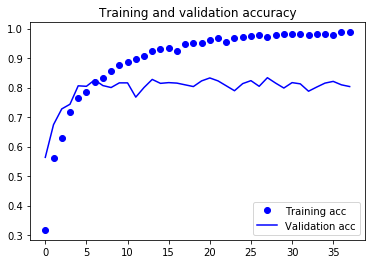

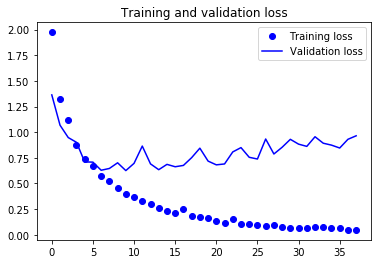

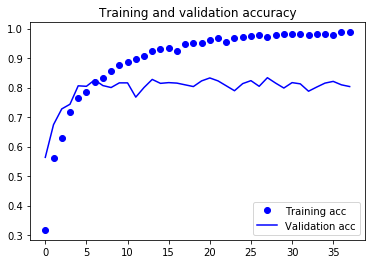

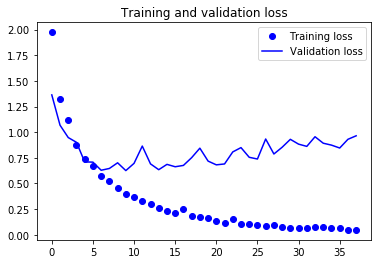

In [94]:
history, model_cnn_aug = runCNNModel(
    X_train_bal_aug,
    X_val_bal,
    y_train_bal_aug,
    y_val_bal, epochs=40, batchsize=200, dropout=0.3)

plotHistory(history)

                   precision    recall  f1-score   support

             axes       0.96      0.93      0.94       100
            boots       0.72      1.00      0.84       100
       carabiners       1.00      0.77      0.87       100
         crampons       0.81      0.95      0.87       100
           gloves       0.71      0.76      0.73       100
hardshell_jackets       0.86      0.61      0.71       100
        harnesses       0.79      0.92      0.85       100
          helmets       0.88      0.91      0.90       100
insulated_jackets       0.77      0.89      0.82       100
          pulleys       0.84      0.57      0.68       100
             rope       0.83      0.86      0.84       100
            tents       1.00      0.83      0.91       100

      avg / total       0.85      0.83      0.83      1200

                   precision    recall  f1-score   support

             axes       0.00      0.00      0.00        30
            boots       0.16      0.27      0.20    

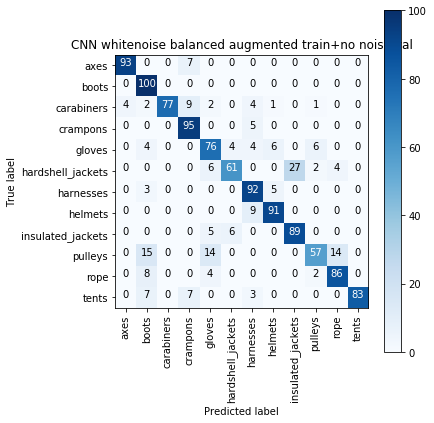

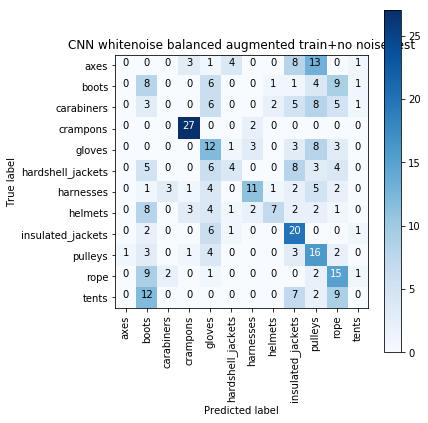

In [96]:
CNNEvaluate(model_cnn_aug, 
            X_val_bal,
            y_val_bal, 
            title='CNN whitenoise balanced augmented train+no noise val')

CNNEvaluate(model_cnn_aug, 
            X_test,
            y_test, 
            title='CNN whitenoise balanced augmented train+no noise test')

We do get slightly better transferability to the test set (0.29)

Just to close the loop on this one, let's try transfer learning and see if it's any better

In [97]:
from keras.applications import Xception

def runCNNTransferModel( xtr, xte, ytr, yte, epochs=5, batchsize=100, dropout=0.4 ):
    
    conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))
    
    conv_base.trainable = False
    
    xtr_1 = addColourDimension(xtr)
    xte_1 = addColourDimension(xte)
    ytr_1 = to_categorical(ytr, num_classes=12)
    yte_1 = to_categorical(yte, num_classes=12)
    
    model = Sequential()
    # clever trick to "learn" a colour mapping from black and white into the the colour channels of
    # the pretrained Xception model
    model.add(Conv2D(10, kernel_size = (1,1), input_shape=(128, 128, 1), padding = 'same', activation = 'relu'))
    model.add(Conv2D(3, kernel_size = (1,1), padding = 'same', activation = 'relu'))
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(12, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [ EarlyStopping(
        monitor='val_acc', 
        min_delta=0, 
        patience=10, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        # this will restore the best weights back to the model
        restore_best_weights=True) ]
    
    #train the model
    history = model.fit(xtr_1, ytr_1, 
                        epochs=epochs, batch_size=batchsize, 
                        validation_data=(xte_1, yte_1),
                        callbacks=callbacks, verbose=1)
    
    plotHistory(history)
    
    return history, model



First of all we can try training on the external test set itself to see what the best possible performance could be

Train on 359 samples, validate on 359 samples
Epoch 1/40
359/359 [==============================] - 7s 19ms/step - loss: 3.1757 - acc: 0.0780 - val_loss: 3.4094 - val_acc: 0.1504
Epoch 2/40
359/359 [==============================] - 1s 2ms/step - loss: 3.4436 - acc: 0.2897 - val_loss: 3.1229 - val_acc: 0.2006
Epoch 3/40
359/359 [==============================] - 1s 2ms/step - loss: 2.3973 - acc: 0.5682 - val_loss: 2.7281 - val_acc: 0.2507
Epoch 4/40
359/359 [==============================] - 1s 2ms/step - loss: 1.5773 - acc: 0.7799 - val_loss: 2.4494 - val_acc: 0.2981
Epoch 5/40
359/359 [==============================] - 1s 2ms/step - loss: 1.0136 - acc: 0.8412 - val_loss: 2.0411 - val_acc: 0.3816
Epoch 6/40
359/359 [==============================] - 1s 2ms/step - loss: 0.4644 - acc: 0.9276 - val_loss: 2.1089 - val_acc: 0.3733
Epoch 7/40
359/359 [==============================] - 1s 2ms/step - loss: 0.4329 - acc: 0.9359 - val_loss: 2.1085 - val_acc: 0.3315
Epoch 8/40
359/359 [=========

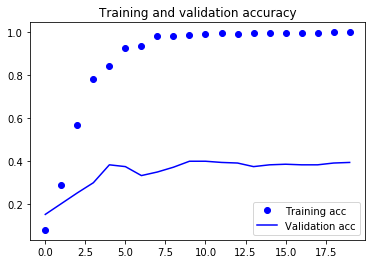

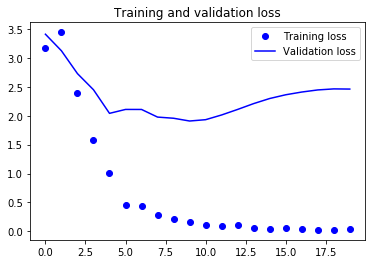

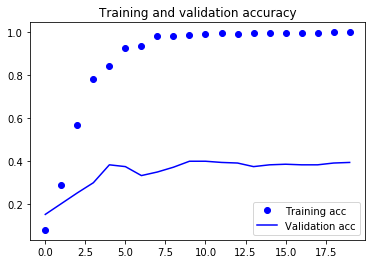

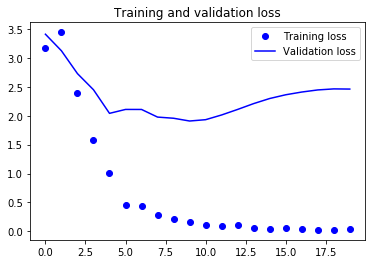

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                   precision    recall  f1-score   support

             axes       0.26      0.40      0.32        30
            boots       0.75      0.40      0.52        30
       carabiners       0.31      0.37      0.34        30
         crampons       0.00      0.00      0.00        29
           gloves       0.32      0.60      0.42        30
hardshell_jackets       0.21      0.43      0.29        30
        harnesses       0.83      0.17      0.28        30
          helmets       0.57      0.27      0.36        30
insulated_jackets       0.42      0.60      0.49        30
          pulleys       0.38      0.70      0.49        30
             rope       0.93      0.47      0.62        30
            tents       1.00      0.37      0.54        30

      avg / total       0.50      0.40      0.39       359



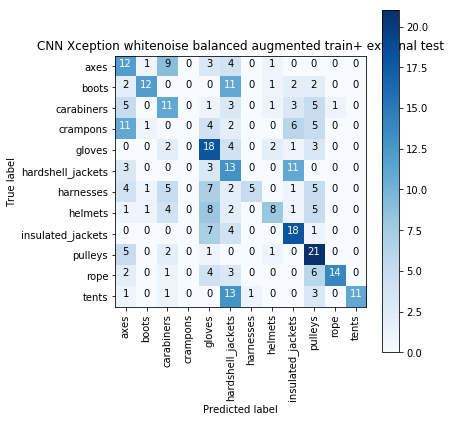

In [128]:
history, model2 = runCNNTransferModel(
    X_test,
    X_test,
    y_test,
    y_test, epochs=40, batchsize=200, dropout=0.65)

plotHistory(history)

CNNEvaluate(model2, 
            X_test,
            y_test, 
            title='CNN Xception baseline training on test')

As you can see, with real-world images -- this is extremely difficult! We are getting 0.39 f-1 baseline so it should in theory be almost impossible to improve on this baseline

Train on 15000 samples, validate on 1200 samples
Epoch 1/40
15000/15000 [==============================] - 27s 2ms/step - loss: 0.4387 - acc: 0.8882 - val_loss: 0.8312 - val_acc: 0.8708
Epoch 2/40
15000/15000 [==============================] - 20s 1ms/step - loss: 0.1081 - acc: 0.9718 - val_loss: 1.2555 - val_acc: 0.8458
Epoch 3/40
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0871 - acc: 0.9789 - val_loss: 1.1163 - val_acc: 0.8650
Epoch 4/40
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0709 - acc: 0.9839 - val_loss: 0.8290 - val_acc: 0.8858
Epoch 5/40
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0384 - acc: 0.9897 - val_loss: 0.8897 - val_acc: 0.8892
Epoch 6/40
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0338 - acc: 0.9913 - val_loss: 1.2084 - val_acc: 0.8733
Epoch 7/40
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0373 - acc: 0.9897 - val_loss: 1.4199 - val_acc:

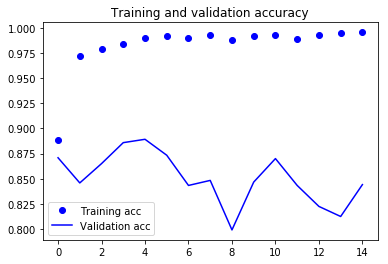

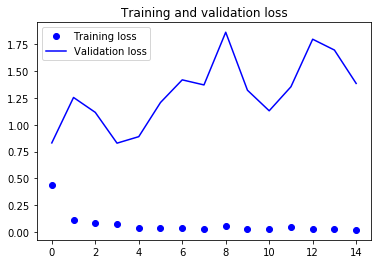

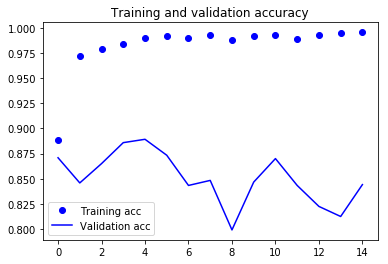

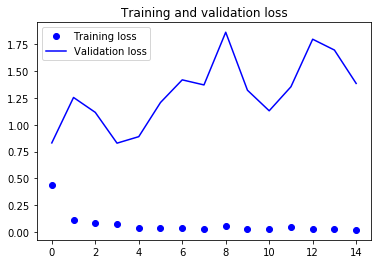

                   precision    recall  f1-score   support

             axes       0.39      0.23      0.29        30
            boots       0.58      0.23      0.33        30
       carabiners       0.54      0.43      0.48        30
         crampons       0.61      0.76      0.68        29
           gloves       0.35      0.23      0.28        30
hardshell_jackets       0.53      0.27      0.36        30
        harnesses       0.27      0.87      0.42        30
          helmets       0.56      0.63      0.59        30
insulated_jackets       0.44      0.47      0.45        30
          pulleys       0.70      0.47      0.56        30
             rope       0.86      0.63      0.73        30
            tents       0.77      0.80      0.79        30

      avg / total       0.55      0.50      0.50       359



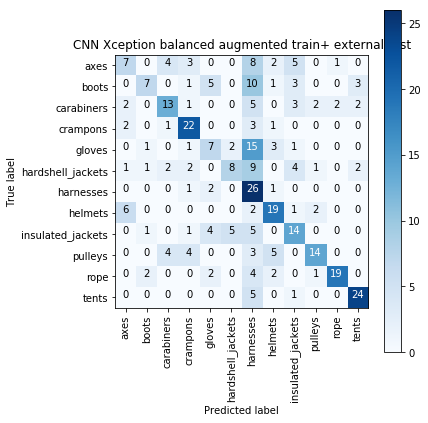

In [98]:
history, model2 = runCNNTransferModel(
    X_train_bal_aug,
    X_val_bal,
    y_train_bal_aug,
    y_val_bal, epochs=40, batchsize=200, dropout=0.65)

plotHistory(history)

CNNEvaluate(model2, 
            X_test,
            y_test, 
            title='CNN Xception balanced augmented train+ external test')

This is actually quite impressive, we are getting .5 on the external test set! Not brilliant but it's *something*

On some classes it seems to do quite well, especially tents which is a hard one on the test set.

One thing which might be going on here is that there are some classes which the convolutional base has higher level representations for, learned from imagenet (tents perhaps?)

Still -- this is an impressive result - better than the baseline and a LOT better than all the other algorithms on the external test set. 

Let's try the same for the noise dataset

The next frontier! LIME! We can use Lime to explain to us how our classifiers are working. Currently I am struggling to get it to work well so we will have to leave that for another day. 

Wall time: 8.91 s


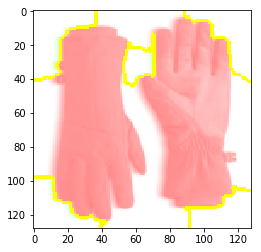

In [612]:
%%time

from lime import lime_image
import time
from keras.utils import to_categorical
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def predict_fn_id3(images):
    xf = flattenImage(images)
    xf = np.mean(xf,axis=2)
    xf = xf.reshape(xf.shape[0],xf.shape[1])
    return clf.predict_proba(xf)

def predict_fn_cnn(images):
    images = np.mean(images,axis=3)
    images = images.reshape(images.shape[0],128,128,1)
    return model.predict(images)

explanation = explainer.explain_instance(X_test[480], 
                                         predict_fn_cnn, 
                                         top_labels=12,
                                         hide_color=False, 
                                         num_samples=5000,
                                         num_features=100000,
                                         random_seed=42)

temp, mask = explanation.get_image_and_mask(imageTypes['gloves'], 
                                            positive_only=False, 
                                            num_features=100000, 
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Lime gives me different results every time, does not show prediction affinities against whitespace, and I assume the contigous pixel segmentation algorithm doesnt work on the whitespace. Let's move to good old SHAP ;)

See below for an illustration of how this visualisation looks like for mnist

<img src="mnist_shap.PNG" style="width: 80%" />

In [101]:
%%time
import numpy as np
import shap

def ShapInspection( Xtr, Xte, model, background_count=10, test_count=20 ):

    # select a set of background examples to take an expectation over
    background = Xtr[np.random.choice(Xtr.shape[0], background_count, replace=False)]
    background = addColourDimension(background)

    # explain predictions of the model on four images
    e = shap.DeepExplainer(model, background)

    random_val = np.random.choice(Xte.shape[0], test_count, replace=False)

    # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
    shap_values = e.shap_values(addColourDimension(Xte[random_val]))

    # plot the feature attributions
    shap.image_plot(shap_values, 
                    -addColourDimension(Xte[random_val]), 
                   # looking at source, seems this is labels for the examples, not classes, duh
                   # labels=np.array(list(imageTypes.keys())),
                    show=True)

Wall time: 0 ns


In [105]:
print( enumerate( imageTypes.keys() ) | as_list )

[(0, 'axes'), (1, 'boots'), (2, 'carabiners'), (3, 'crampons'), (4, 'gloves'), (5, 'hardshell_jackets'), (6, 'harnesses'), (7, 'helmets'), (8, 'insulated_jackets'), (9, 'pulleys'), (10, 'rope'), (11, 'tents')]


Let's evaluate SHAP on the transfer learning model

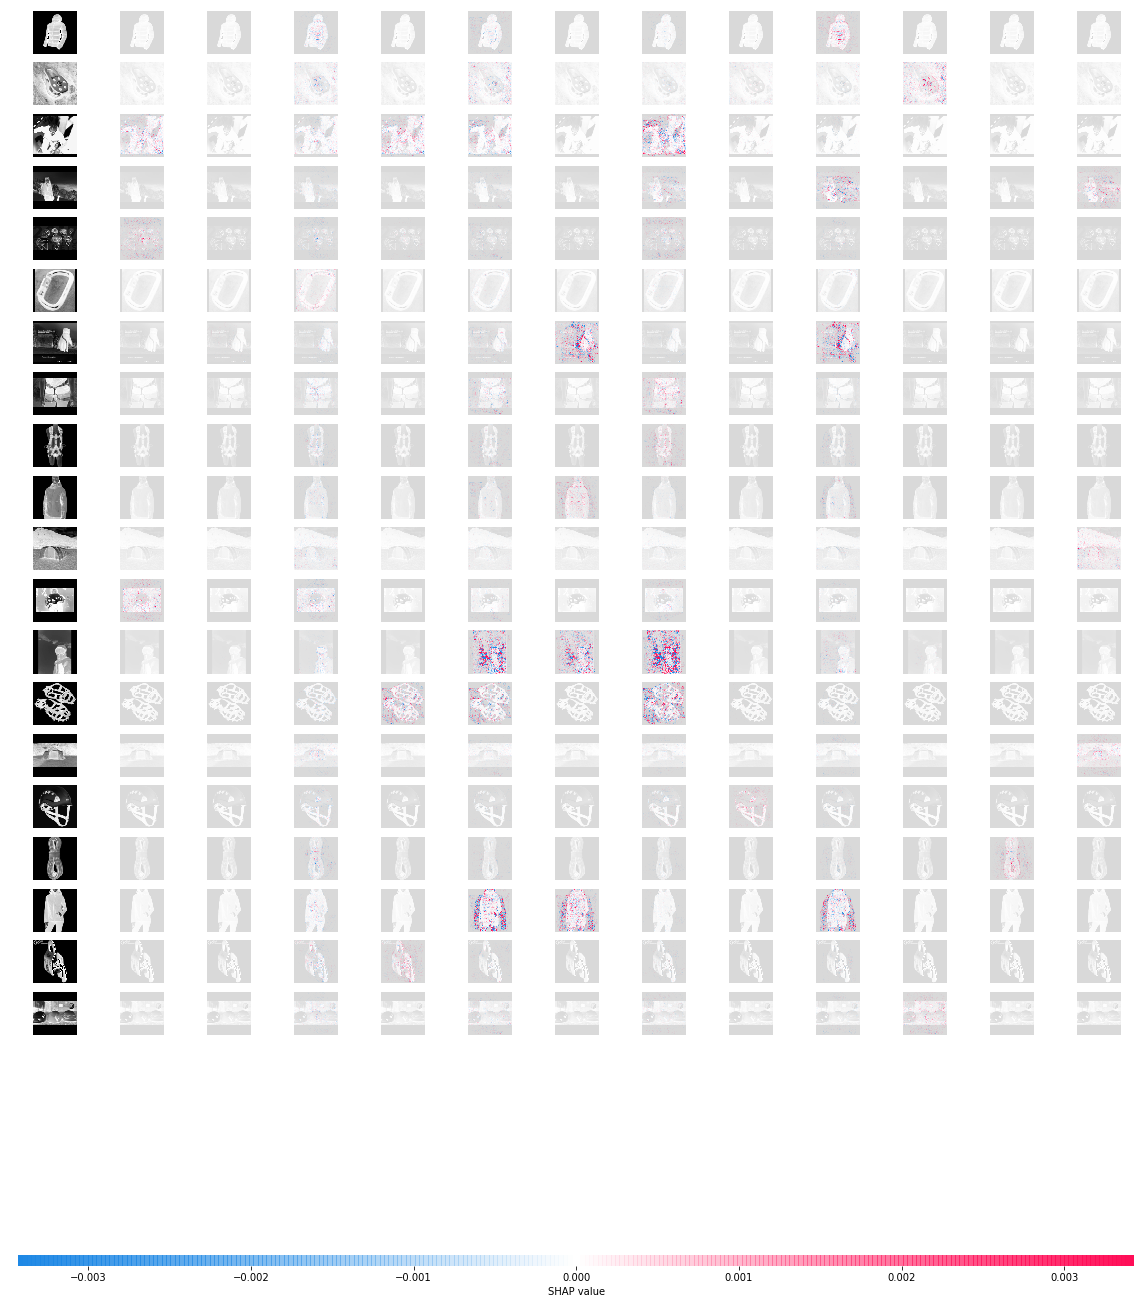

Wall time: 1min 6s


In [102]:
%%time
ShapInspection(X_train, X_test, model2) 

Here we can really see some local activation, 

* it seems to be learning the subject of focus
* on the jackets, it seems to be looking for the shame in the middle of the picture even if the test image doesn't fill it out!
* On the pulley example, it's clearly learning the characteristic holes in the pulley

And on the vanilla CNN model

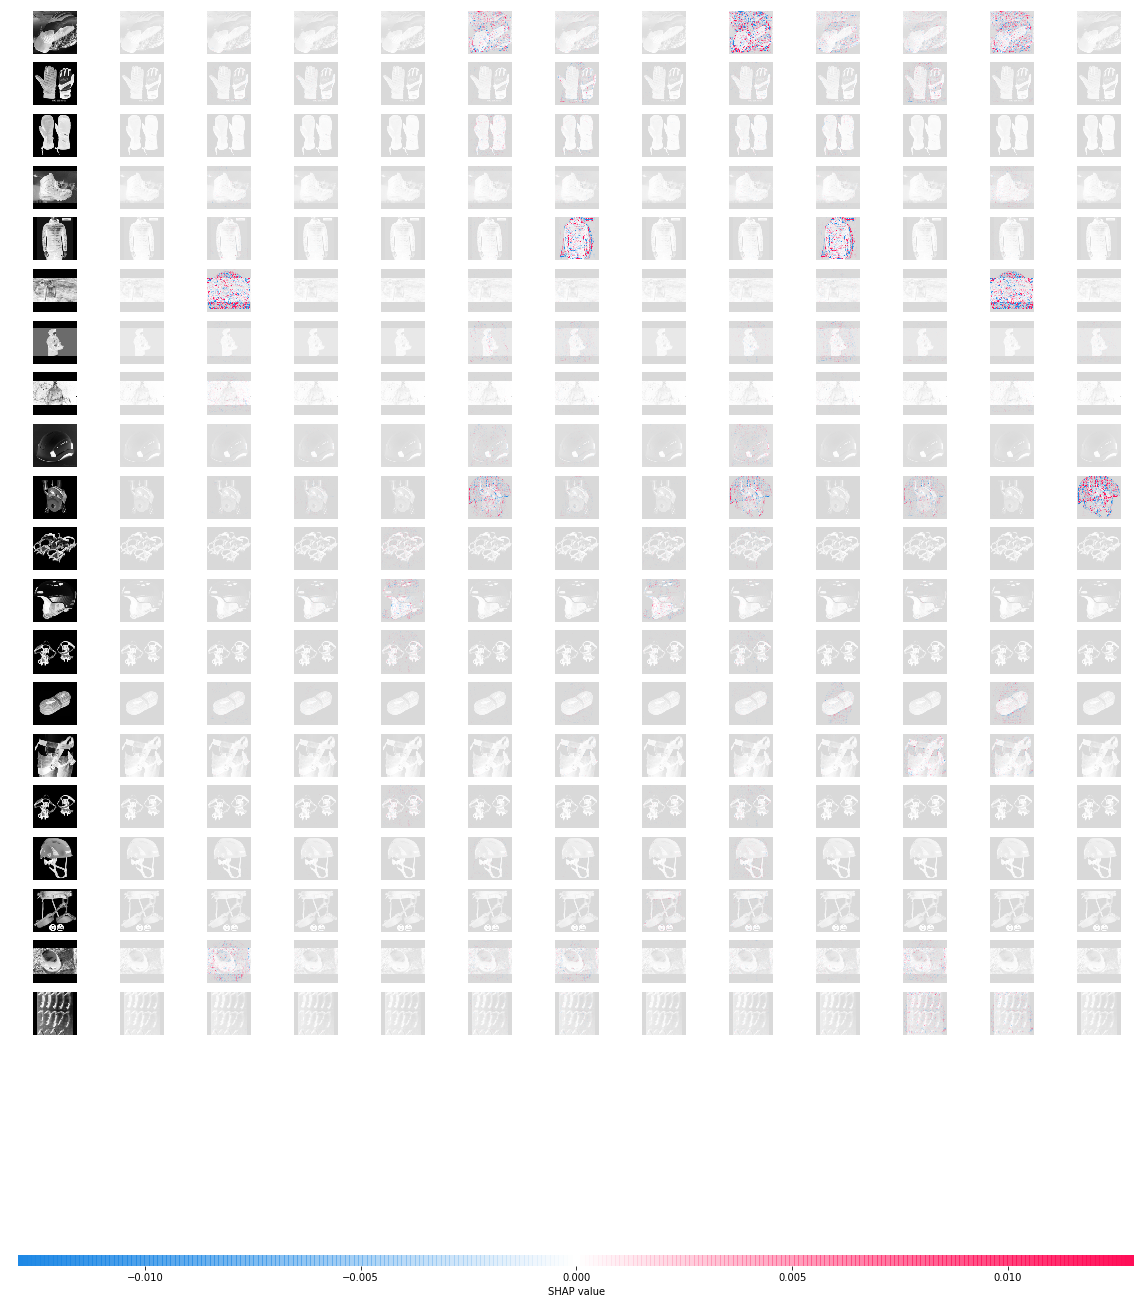

Wall time: 39.2 s


In [106]:

%%time
ShapInspection(X_train, X_test, model_cnn_aug) 


* On one of these you can even see it trying to activate the shape of a helmet even though it's a pulley!